In [0]:
import keras #an open-source neural-network library written in Python
import pandas as pd # pandas is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.
import numpy as np # NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import matplotlib.pyplot as plt #is a state-based interface to matplotlib. It provides a MATLAB-like way of plotting.pyplot is mainly intended for interactive plots and simple cases of programmatic plot generation:
from scipy.interpolate import interp1d #Sub-package for objects used in interpolation.As listed, this sub-package contains spline functions and classes, one-dimensional and multi-dimensional (univariate and multivariate) interpolation classes

In [0]:
# Downloads data from central site
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [0]:
x_train = x_train/127.5-1 #Fix image rescaling to

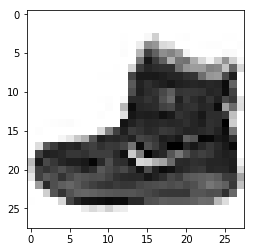

In [17]:
#Display image as grayscale using matplotlib
plt.imshow(x_train[0], cmap='Greys')

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D #Upsampling layer for 2D inputs.Repeats the rows and columns of the data by size[0] and size[1] respectivel
from keras.models import Sequential, Model # The Sequential model is a linear stack of layers.You can create a Sequential model by passing a list of layer instances to the constructor:
from keras.optimizers import Adam #An optimizer is one of the two arguments required for compiling a Keras model Adam optimizer. Default parameters follow those provided in the original paper
from keras.layers import BatchNormalization, Activation, ZeroPadding2D #Batch normalization layer (Ioffe and Szegedy, 2014).Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1 and Applies an activation function to an output Zero-padding layer for 2D input (e.g. picture).This layer can add rows and columns of zeros at the top, bottom, left and right side of an image tensor
from keras.layers.advanced_activations import LeakyReLU # Leaky version of a Rectified Linear Unit. It allows a small gradient when the unit is not active

In [0]:
x_train = np.expand_dims(x_train, axis=3) # Expand the shape of an array. Insert a new axis that will appear at the axis position in the expanded array shape.

In [20]:
def create_generator():
  model = Sequential()

  model.add(Dense(256, input_dim=100)) # Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))
  
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(1024))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(np.prod((28, 28, 1)), activation='tanh'))
  model.add(Reshape((28, 28, 1))) #Reshapes an output to a certain shape

  model.summary() #prints a summary representation of your model. For layers with multiple outputs, multiple is displayed instead of each individual output shape due to size limitations. Shortcut for utils.print_summary

  noise = Input(shape=(100,)) # To define 
  img = model(noise)

  return Model(noise, img)

generator = create_generator() # Generator’s objective will be to generate data that is very similar to the training data
z = Input(shape=(100,))
img = generator(z) # To define

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 1024)             

Non-trainable parameters of a model are those that you will not be updating and optimized during training, and that have to be defined a priori, or passed as inputs.

In [21]:
def create_discriminator():
  model = Sequential()

  model.add(Flatten(input_shape=(28, 28, 1)))
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=(28, 28, 1))
  validity = model(img)

  return Model(img, validity)

discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

Discriminator takes two sets of input, one input comes from the training dataset(real data) and the other input is the dataset generated by Generator

Binary crossentropy between an output tensor and a target tensor.

Arguments

target: A tensor with the same shape as output.
output: A tensor.
from_logits: Whether output is expected to be a logits tensor. By default, we consider that output encodes a probability distribution.
Returns

A tensor.

In [0]:
validity = discriminator(img)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [0]:
def sample_images(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r*c, 100))
  gen_imgs = generator.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = 0.5*gen_imgs+0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1
  #fig.savefig("images/%d.png" % epoch)
  plt.show()
  plt.close()

Epoch: an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation. meaning the number of epochs means how many times you go through your training set

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.599926, acc.: 68.75%] [G loss: 0.926760]


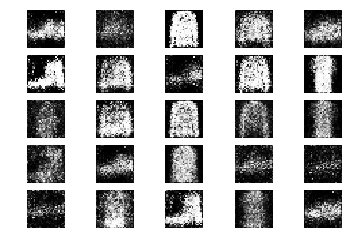

1 [D loss: 0.574290, acc.: 68.75%] [G loss: 0.846971]
2 [D loss: 0.649668, acc.: 62.50%] [G loss: 0.990031]
3 [D loss: 0.507713, acc.: 78.12%] [G loss: 0.941426]
4 [D loss: 0.679209, acc.: 56.25%] [G loss: 1.009294]
5 [D loss: 0.740013, acc.: 50.00%] [G loss: 0.993526]
6 [D loss: 0.573071, acc.: 64.06%] [G loss: 0.981187]
7 [D loss: 0.614083, acc.: 68.75%] [G loss: 0.908638]
8 [D loss: 0.631969, acc.: 65.62%] [G loss: 0.898232]
9 [D loss: 0.613195, acc.: 65.62%] [G loss: 0.907894]
10 [D loss: 0.598731, acc.: 70.31%] [G loss: 0.982875]
11 [D loss: 0.598883, acc.: 68.75%] [G loss: 0.929855]
12 [D loss: 0.686922, acc.: 64.06%] [G loss: 0.898180]
13 [D loss: 0.554469, acc.: 76.56%] [G loss: 0.951223]
14 [D loss: 0.631193, acc.: 67.19%] [G loss: 0.875534]
15 [D loss: 0.511840, acc.: 81.25%] [G loss: 0.891452]
16 [D loss: 0.538252, acc.: 75.00%] [G loss: 0.961484]
17 [D loss: 0.610786, acc.: 65.62%] [G loss: 0.975110]
18 [D loss: 0.678416, acc.: 57.81%] [G loss: 0.995567]
19 [D loss: 0.59827

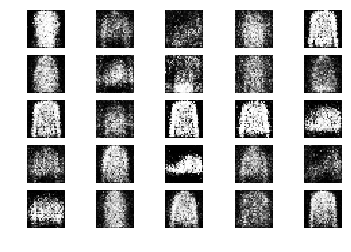

51 [D loss: 0.626696, acc.: 64.06%] [G loss: 0.939681]
52 [D loss: 0.610265, acc.: 68.75%] [G loss: 0.891835]
53 [D loss: 0.637177, acc.: 64.06%] [G loss: 0.889507]
54 [D loss: 0.638238, acc.: 68.75%] [G loss: 0.858688]
55 [D loss: 0.663783, acc.: 64.06%] [G loss: 0.893875]
56 [D loss: 0.698067, acc.: 53.12%] [G loss: 0.828704]
57 [D loss: 0.647163, acc.: 59.38%] [G loss: 0.908507]
58 [D loss: 0.690146, acc.: 50.00%] [G loss: 0.890349]
59 [D loss: 0.566457, acc.: 71.88%] [G loss: 0.908216]
60 [D loss: 0.650524, acc.: 60.94%] [G loss: 0.894449]
61 [D loss: 0.608184, acc.: 64.06%] [G loss: 0.945290]
62 [D loss: 0.623386, acc.: 64.06%] [G loss: 0.935121]
63 [D loss: 0.628486, acc.: 64.06%] [G loss: 1.029477]
64 [D loss: 0.639151, acc.: 65.62%] [G loss: 0.922382]
65 [D loss: 0.608500, acc.: 68.75%] [G loss: 1.005113]
66 [D loss: 0.588651, acc.: 68.75%] [G loss: 0.968597]
67 [D loss: 0.603881, acc.: 67.19%] [G loss: 0.963633]
68 [D loss: 0.702914, acc.: 57.81%] [G loss: 0.933325]
69 [D loss

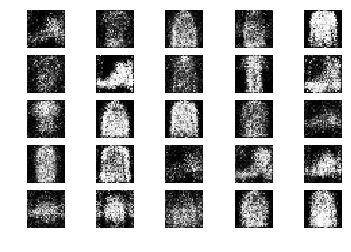

101 [D loss: 0.644852, acc.: 56.25%] [G loss: 1.006395]
102 [D loss: 0.620809, acc.: 62.50%] [G loss: 0.930496]
103 [D loss: 0.597701, acc.: 67.19%] [G loss: 0.958696]
104 [D loss: 0.605875, acc.: 70.31%] [G loss: 0.972868]
105 [D loss: 0.622720, acc.: 67.19%] [G loss: 1.021608]
106 [D loss: 0.641317, acc.: 67.19%] [G loss: 0.962275]
107 [D loss: 0.670435, acc.: 59.38%] [G loss: 0.944304]
108 [D loss: 0.624777, acc.: 65.62%] [G loss: 0.936929]
109 [D loss: 0.552886, acc.: 75.00%] [G loss: 0.996137]
110 [D loss: 0.606070, acc.: 68.75%] [G loss: 0.767154]
111 [D loss: 0.630431, acc.: 73.44%] [G loss: 0.907797]
112 [D loss: 0.680788, acc.: 54.69%] [G loss: 0.935720]
113 [D loss: 0.593234, acc.: 64.06%] [G loss: 0.976236]
114 [D loss: 0.735158, acc.: 51.56%] [G loss: 0.954547]
115 [D loss: 0.643089, acc.: 60.94%] [G loss: 0.974030]
116 [D loss: 0.749965, acc.: 51.56%] [G loss: 0.877326]
117 [D loss: 0.642652, acc.: 70.31%] [G loss: 0.870810]
118 [D loss: 0.570854, acc.: 76.56%] [G loss: 1.

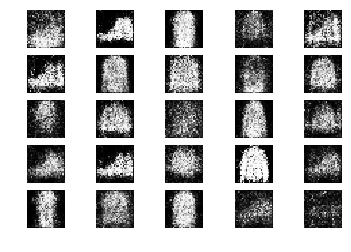

151 [D loss: 0.647368, acc.: 67.19%] [G loss: 0.978693]
152 [D loss: 0.622480, acc.: 68.75%] [G loss: 0.849831]
153 [D loss: 0.663065, acc.: 64.06%] [G loss: 0.870282]
154 [D loss: 0.606816, acc.: 67.19%] [G loss: 1.017831]
155 [D loss: 0.595689, acc.: 67.19%] [G loss: 0.872461]
156 [D loss: 0.585379, acc.: 65.62%] [G loss: 0.834286]
157 [D loss: 0.554096, acc.: 78.12%] [G loss: 0.950964]
158 [D loss: 0.589994, acc.: 67.19%] [G loss: 1.004161]
159 [D loss: 0.633359, acc.: 65.62%] [G loss: 0.965742]
160 [D loss: 0.568147, acc.: 70.31%] [G loss: 0.986171]
161 [D loss: 0.607586, acc.: 65.62%] [G loss: 0.948539]
162 [D loss: 0.639017, acc.: 68.75%] [G loss: 0.972215]
163 [D loss: 0.628322, acc.: 65.62%] [G loss: 0.953905]
164 [D loss: 0.601417, acc.: 60.94%] [G loss: 0.919016]
165 [D loss: 0.635493, acc.: 70.31%] [G loss: 0.930828]
166 [D loss: 0.603442, acc.: 75.00%] [G loss: 0.928862]
167 [D loss: 0.639718, acc.: 60.94%] [G loss: 0.867176]
168 [D loss: 0.654317, acc.: 54.69%] [G loss: 0.

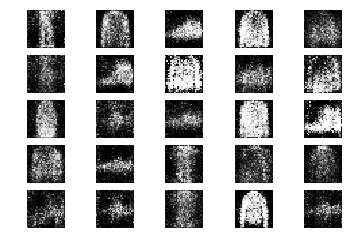

201 [D loss: 0.633806, acc.: 59.38%] [G loss: 0.948663]
202 [D loss: 0.524267, acc.: 73.44%] [G loss: 0.888560]
203 [D loss: 0.601065, acc.: 64.06%] [G loss: 0.924479]
204 [D loss: 0.668866, acc.: 57.81%] [G loss: 0.986667]
205 [D loss: 0.585124, acc.: 71.88%] [G loss: 0.863915]
206 [D loss: 0.644286, acc.: 67.19%] [G loss: 0.949313]
207 [D loss: 0.601885, acc.: 67.19%] [G loss: 0.914195]
208 [D loss: 0.619217, acc.: 67.19%] [G loss: 0.903642]
209 [D loss: 0.569829, acc.: 70.31%] [G loss: 0.918437]
210 [D loss: 0.604850, acc.: 67.19%] [G loss: 0.975973]
211 [D loss: 0.542585, acc.: 70.31%] [G loss: 0.934345]
212 [D loss: 0.671646, acc.: 59.38%] [G loss: 0.872598]
213 [D loss: 0.591963, acc.: 64.06%] [G loss: 0.972085]
214 [D loss: 0.621462, acc.: 68.75%] [G loss: 0.937158]
215 [D loss: 0.627785, acc.: 70.31%] [G loss: 0.926961]
216 [D loss: 0.632153, acc.: 60.94%] [G loss: 0.944404]
217 [D loss: 0.643366, acc.: 60.94%] [G loss: 0.824663]
218 [D loss: 0.609501, acc.: 70.31%] [G loss: 0.

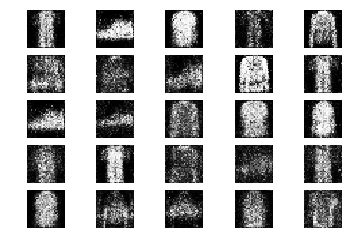

251 [D loss: 0.583077, acc.: 70.31%] [G loss: 0.946133]
252 [D loss: 0.633397, acc.: 65.62%] [G loss: 0.870524]
253 [D loss: 0.653899, acc.: 54.69%] [G loss: 0.982831]
254 [D loss: 0.648180, acc.: 64.06%] [G loss: 0.947128]
255 [D loss: 0.639852, acc.: 67.19%] [G loss: 0.915715]
256 [D loss: 0.629062, acc.: 65.62%] [G loss: 0.994157]
257 [D loss: 0.637474, acc.: 64.06%] [G loss: 0.908502]
258 [D loss: 0.587148, acc.: 71.88%] [G loss: 0.869971]
259 [D loss: 0.532303, acc.: 81.25%] [G loss: 0.797843]
260 [D loss: 0.636364, acc.: 67.19%] [G loss: 0.869251]
261 [D loss: 0.683453, acc.: 60.94%] [G loss: 0.910096]
262 [D loss: 0.573254, acc.: 68.75%] [G loss: 0.901234]
263 [D loss: 0.582303, acc.: 68.75%] [G loss: 0.873828]
264 [D loss: 0.609812, acc.: 71.88%] [G loss: 0.850096]
265 [D loss: 0.619972, acc.: 68.75%] [G loss: 0.912167]
266 [D loss: 0.552722, acc.: 76.56%] [G loss: 0.862645]
267 [D loss: 0.686008, acc.: 59.38%] [G loss: 0.978145]
268 [D loss: 0.637142, acc.: 60.94%] [G loss: 0.

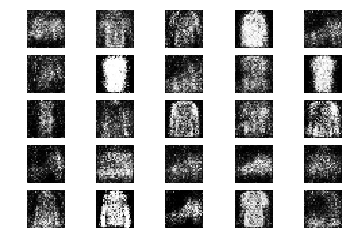

301 [D loss: 0.613063, acc.: 68.75%] [G loss: 0.866048]
302 [D loss: 0.676492, acc.: 57.81%] [G loss: 0.865283]
303 [D loss: 0.666386, acc.: 62.50%] [G loss: 0.903616]
304 [D loss: 0.666388, acc.: 53.12%] [G loss: 0.889230]
305 [D loss: 0.621816, acc.: 65.62%] [G loss: 0.836538]
306 [D loss: 0.674941, acc.: 59.38%] [G loss: 0.996100]
307 [D loss: 0.624712, acc.: 70.31%] [G loss: 0.984836]
308 [D loss: 0.633375, acc.: 57.81%] [G loss: 0.919244]
309 [D loss: 0.572816, acc.: 71.88%] [G loss: 0.933375]
310 [D loss: 0.677273, acc.: 54.69%] [G loss: 0.954709]
311 [D loss: 0.675629, acc.: 60.94%] [G loss: 0.857009]
312 [D loss: 0.595765, acc.: 71.88%] [G loss: 0.925649]
313 [D loss: 0.633394, acc.: 65.62%] [G loss: 0.915906]
314 [D loss: 0.657929, acc.: 56.25%] [G loss: 0.936554]
315 [D loss: 0.647484, acc.: 54.69%] [G loss: 0.870034]
316 [D loss: 0.683251, acc.: 53.12%] [G loss: 0.916764]
317 [D loss: 0.652156, acc.: 60.94%] [G loss: 0.897581]
318 [D loss: 0.619549, acc.: 65.62%] [G loss: 0.

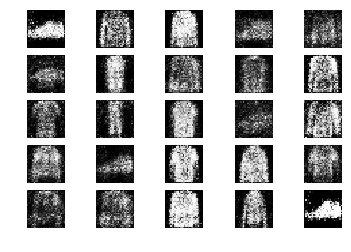

351 [D loss: 0.568188, acc.: 76.56%] [G loss: 0.942064]
352 [D loss: 0.581551, acc.: 71.88%] [G loss: 0.959596]
353 [D loss: 0.629956, acc.: 62.50%] [G loss: 1.034569]
354 [D loss: 0.656104, acc.: 60.94%] [G loss: 0.993081]
355 [D loss: 0.589731, acc.: 71.88%] [G loss: 0.936363]
356 [D loss: 0.647074, acc.: 59.38%] [G loss: 0.914004]
357 [D loss: 0.629208, acc.: 65.62%] [G loss: 0.871200]
358 [D loss: 0.595965, acc.: 70.31%] [G loss: 0.897291]
359 [D loss: 0.675815, acc.: 57.81%] [G loss: 0.824595]
360 [D loss: 0.544343, acc.: 79.69%] [G loss: 0.867414]
361 [D loss: 0.656591, acc.: 53.12%] [G loss: 0.898300]
362 [D loss: 0.610520, acc.: 62.50%] [G loss: 0.808408]
363 [D loss: 0.581424, acc.: 64.06%] [G loss: 0.939673]
364 [D loss: 0.536468, acc.: 73.44%] [G loss: 0.874972]
365 [D loss: 0.651937, acc.: 59.38%] [G loss: 0.920614]
366 [D loss: 0.664922, acc.: 57.81%] [G loss: 0.887146]
367 [D loss: 0.575862, acc.: 67.19%] [G loss: 0.923565]
368 [D loss: 0.608850, acc.: 62.50%] [G loss: 0.

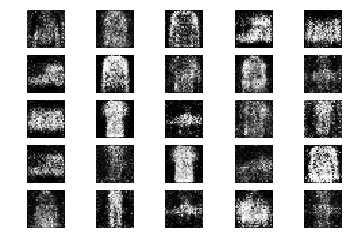

401 [D loss: 0.601065, acc.: 68.75%] [G loss: 1.004336]
402 [D loss: 0.620363, acc.: 73.44%] [G loss: 0.870355]
403 [D loss: 0.642389, acc.: 64.06%] [G loss: 0.846560]
404 [D loss: 0.584584, acc.: 71.88%] [G loss: 0.876757]
405 [D loss: 0.601428, acc.: 71.88%] [G loss: 0.944757]
406 [D loss: 0.687501, acc.: 56.25%] [G loss: 0.928206]
407 [D loss: 0.628508, acc.: 62.50%] [G loss: 0.984220]
408 [D loss: 0.647979, acc.: 60.94%] [G loss: 1.003523]
409 [D loss: 0.759257, acc.: 43.75%] [G loss: 1.037771]
410 [D loss: 0.609764, acc.: 62.50%] [G loss: 0.972838]
411 [D loss: 0.671886, acc.: 57.81%] [G loss: 0.957540]
412 [D loss: 0.671824, acc.: 51.56%] [G loss: 0.857158]
413 [D loss: 0.597818, acc.: 64.06%] [G loss: 0.877539]
414 [D loss: 0.632391, acc.: 62.50%] [G loss: 0.880921]
415 [D loss: 0.629750, acc.: 62.50%] [G loss: 0.915066]
416 [D loss: 0.587087, acc.: 71.88%] [G loss: 0.917769]
417 [D loss: 0.603829, acc.: 70.31%] [G loss: 0.961038]
418 [D loss: 0.626621, acc.: 67.19%] [G loss: 0.

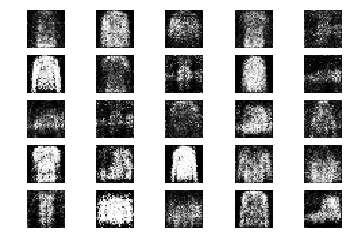

451 [D loss: 0.605239, acc.: 75.00%] [G loss: 0.855132]
452 [D loss: 0.630458, acc.: 62.50%] [G loss: 0.852853]
453 [D loss: 0.618863, acc.: 67.19%] [G loss: 0.896707]
454 [D loss: 0.674878, acc.: 59.38%] [G loss: 0.886859]
455 [D loss: 0.582909, acc.: 67.19%] [G loss: 0.875513]
456 [D loss: 0.648771, acc.: 62.50%] [G loss: 0.863722]
457 [D loss: 0.632822, acc.: 62.50%] [G loss: 0.857487]
458 [D loss: 0.669704, acc.: 57.81%] [G loss: 0.864617]
459 [D loss: 0.660899, acc.: 53.12%] [G loss: 0.827593]
460 [D loss: 0.612007, acc.: 60.94%] [G loss: 0.900089]
461 [D loss: 0.572551, acc.: 71.88%] [G loss: 0.964147]
462 [D loss: 0.599614, acc.: 64.06%] [G loss: 0.824707]
463 [D loss: 0.661781, acc.: 64.06%] [G loss: 0.913093]
464 [D loss: 0.635312, acc.: 59.38%] [G loss: 0.935832]
465 [D loss: 0.609847, acc.: 67.19%] [G loss: 0.866330]
466 [D loss: 0.662308, acc.: 65.62%] [G loss: 0.988501]
467 [D loss: 0.663034, acc.: 54.69%] [G loss: 0.935372]
468 [D loss: 0.644416, acc.: 65.62%] [G loss: 0.

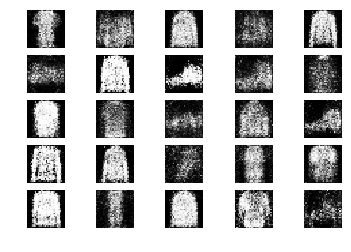

501 [D loss: 0.675468, acc.: 57.81%] [G loss: 0.805345]
502 [D loss: 0.599573, acc.: 65.62%] [G loss: 0.860532]
503 [D loss: 0.609908, acc.: 65.62%] [G loss: 0.848978]
504 [D loss: 0.561637, acc.: 76.56%] [G loss: 0.967025]
505 [D loss: 0.517697, acc.: 87.50%] [G loss: 0.924401]
506 [D loss: 0.610649, acc.: 59.38%] [G loss: 0.862449]
507 [D loss: 0.596722, acc.: 70.31%] [G loss: 0.852391]
508 [D loss: 0.667135, acc.: 60.94%] [G loss: 0.949731]
509 [D loss: 0.610180, acc.: 70.31%] [G loss: 0.979645]
510 [D loss: 0.571252, acc.: 70.31%] [G loss: 0.946935]
511 [D loss: 0.628659, acc.: 67.19%] [G loss: 0.983604]
512 [D loss: 0.627317, acc.: 68.75%] [G loss: 0.962318]
513 [D loss: 0.604276, acc.: 76.56%] [G loss: 0.915181]
514 [D loss: 0.701874, acc.: 56.25%] [G loss: 0.832431]
515 [D loss: 0.670369, acc.: 54.69%] [G loss: 0.916072]
516 [D loss: 0.604319, acc.: 64.06%] [G loss: 0.786442]
517 [D loss: 0.607805, acc.: 67.19%] [G loss: 0.883828]
518 [D loss: 0.615922, acc.: 70.31%] [G loss: 0.

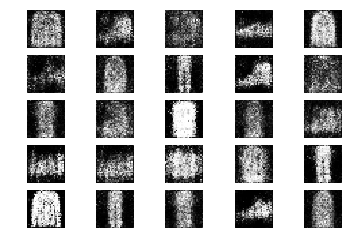

551 [D loss: 0.631611, acc.: 59.38%] [G loss: 0.882342]
552 [D loss: 0.550431, acc.: 73.44%] [G loss: 0.936054]
553 [D loss: 0.616144, acc.: 65.62%] [G loss: 0.861201]
554 [D loss: 0.648457, acc.: 65.62%] [G loss: 0.898181]
555 [D loss: 0.576636, acc.: 64.06%] [G loss: 0.888209]
556 [D loss: 0.684529, acc.: 56.25%] [G loss: 0.889852]
557 [D loss: 0.632078, acc.: 67.19%] [G loss: 0.873896]
558 [D loss: 0.603821, acc.: 70.31%] [G loss: 1.016084]
559 [D loss: 0.606096, acc.: 62.50%] [G loss: 0.934393]
560 [D loss: 0.693263, acc.: 53.12%] [G loss: 0.864006]
561 [D loss: 0.628328, acc.: 64.06%] [G loss: 0.819878]
562 [D loss: 0.685577, acc.: 53.12%] [G loss: 0.878166]
563 [D loss: 0.562108, acc.: 73.44%] [G loss: 0.944657]
564 [D loss: 0.644702, acc.: 57.81%] [G loss: 0.895235]
565 [D loss: 0.635450, acc.: 62.50%] [G loss: 0.879957]
566 [D loss: 0.623175, acc.: 65.62%] [G loss: 0.890140]
567 [D loss: 0.660129, acc.: 60.94%] [G loss: 0.916271]
568 [D loss: 0.651327, acc.: 60.94%] [G loss: 0.

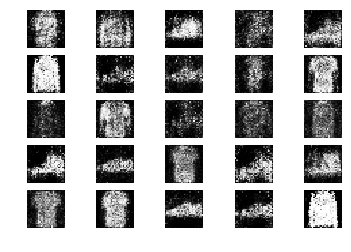

601 [D loss: 0.663337, acc.: 56.25%] [G loss: 0.882895]
602 [D loss: 0.692275, acc.: 51.56%] [G loss: 0.823341]
603 [D loss: 0.604967, acc.: 70.31%] [G loss: 0.878629]
604 [D loss: 0.624335, acc.: 60.94%] [G loss: 0.899102]
605 [D loss: 0.639515, acc.: 60.94%] [G loss: 0.884056]
606 [D loss: 0.647072, acc.: 59.38%] [G loss: 0.944843]
607 [D loss: 0.544464, acc.: 78.12%] [G loss: 0.923247]
608 [D loss: 0.648982, acc.: 64.06%] [G loss: 0.858964]
609 [D loss: 0.622045, acc.: 65.62%] [G loss: 0.823750]
610 [D loss: 0.610758, acc.: 67.19%] [G loss: 1.002174]
611 [D loss: 0.559364, acc.: 70.31%] [G loss: 1.020550]
612 [D loss: 0.626691, acc.: 68.75%] [G loss: 0.901421]
613 [D loss: 0.629079, acc.: 67.19%] [G loss: 0.845338]
614 [D loss: 0.633450, acc.: 59.38%] [G loss: 0.895296]
615 [D loss: 0.608299, acc.: 73.44%] [G loss: 0.962657]
616 [D loss: 0.647843, acc.: 62.50%] [G loss: 0.800109]
617 [D loss: 0.671657, acc.: 62.50%] [G loss: 0.840096]
618 [D loss: 0.666094, acc.: 64.06%] [G loss: 0.

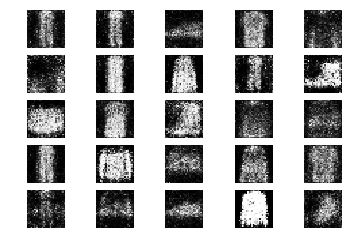

651 [D loss: 0.600397, acc.: 67.19%] [G loss: 0.978214]
652 [D loss: 0.576670, acc.: 76.56%] [G loss: 0.953633]
653 [D loss: 0.667168, acc.: 57.81%] [G loss: 0.934982]
654 [D loss: 0.607845, acc.: 67.19%] [G loss: 0.916778]
655 [D loss: 0.539780, acc.: 76.56%] [G loss: 1.039946]
656 [D loss: 0.663700, acc.: 59.38%] [G loss: 0.939073]
657 [D loss: 0.628763, acc.: 70.31%] [G loss: 0.901694]
658 [D loss: 0.696779, acc.: 51.56%] [G loss: 0.844143]
659 [D loss: 0.720775, acc.: 50.00%] [G loss: 0.863391]
660 [D loss: 0.582749, acc.: 73.44%] [G loss: 0.868116]
661 [D loss: 0.512231, acc.: 75.00%] [G loss: 0.975316]
662 [D loss: 0.641806, acc.: 59.38%] [G loss: 0.952132]
663 [D loss: 0.617914, acc.: 67.19%] [G loss: 0.864564]
664 [D loss: 0.635441, acc.: 57.81%] [G loss: 1.015631]
665 [D loss: 0.604854, acc.: 70.31%] [G loss: 1.034467]
666 [D loss: 0.610868, acc.: 67.19%] [G loss: 0.939240]
667 [D loss: 0.650101, acc.: 56.25%] [G loss: 0.883434]
668 [D loss: 0.641179, acc.: 60.94%] [G loss: 0.

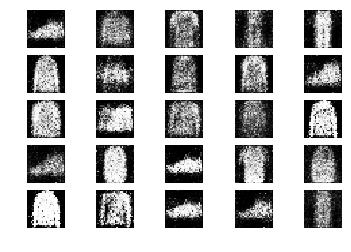

701 [D loss: 0.624607, acc.: 65.62%] [G loss: 0.884389]
702 [D loss: 0.646352, acc.: 62.50%] [G loss: 0.966371]
703 [D loss: 0.604157, acc.: 71.88%] [G loss: 0.957988]
704 [D loss: 0.630804, acc.: 64.06%] [G loss: 0.945898]
705 [D loss: 0.597555, acc.: 68.75%] [G loss: 0.926017]
706 [D loss: 0.584918, acc.: 68.75%] [G loss: 0.996542]
707 [D loss: 0.634075, acc.: 73.44%] [G loss: 0.915352]
708 [D loss: 0.562121, acc.: 76.56%] [G loss: 0.937311]
709 [D loss: 0.612794, acc.: 67.19%] [G loss: 0.937470]
710 [D loss: 0.631423, acc.: 68.75%] [G loss: 0.981489]
711 [D loss: 0.653222, acc.: 64.06%] [G loss: 0.963256]
712 [D loss: 0.601373, acc.: 64.06%] [G loss: 0.940947]
713 [D loss: 0.600414, acc.: 65.62%] [G loss: 0.907051]
714 [D loss: 0.610428, acc.: 68.75%] [G loss: 0.892544]
715 [D loss: 0.612730, acc.: 60.94%] [G loss: 0.925382]
716 [D loss: 0.562438, acc.: 75.00%] [G loss: 0.898823]
717 [D loss: 0.633968, acc.: 64.06%] [G loss: 0.758383]
718 [D loss: 0.734697, acc.: 56.25%] [G loss: 0.

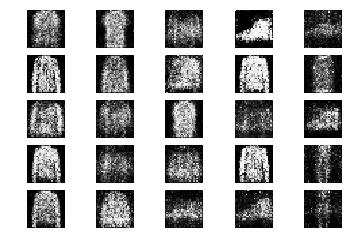

751 [D loss: 0.555311, acc.: 78.12%] [G loss: 0.878089]
752 [D loss: 0.642017, acc.: 59.38%] [G loss: 0.872314]
753 [D loss: 0.597889, acc.: 68.75%] [G loss: 0.902136]
754 [D loss: 0.618577, acc.: 68.75%] [G loss: 0.935689]
755 [D loss: 0.612055, acc.: 65.62%] [G loss: 0.760294]
756 [D loss: 0.632220, acc.: 60.94%] [G loss: 0.838506]
757 [D loss: 0.615688, acc.: 59.38%] [G loss: 0.848023]
758 [D loss: 0.575907, acc.: 68.75%] [G loss: 0.965177]
759 [D loss: 0.634666, acc.: 65.62%] [G loss: 0.895800]
760 [D loss: 0.600769, acc.: 71.88%] [G loss: 0.897056]
761 [D loss: 0.558386, acc.: 76.56%] [G loss: 1.069196]
762 [D loss: 0.599592, acc.: 64.06%] [G loss: 1.011068]
763 [D loss: 0.644883, acc.: 54.69%] [G loss: 0.874411]
764 [D loss: 0.584313, acc.: 76.56%] [G loss: 0.817498]
765 [D loss: 0.687174, acc.: 59.38%] [G loss: 0.787477]
766 [D loss: 0.615140, acc.: 56.25%] [G loss: 0.849489]
767 [D loss: 0.596874, acc.: 70.31%] [G loss: 0.952615]
768 [D loss: 0.683919, acc.: 59.38%] [G loss: 0.

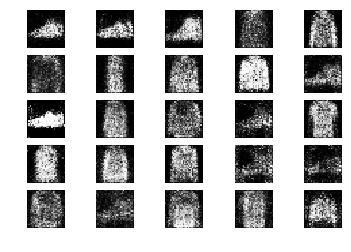

801 [D loss: 0.630554, acc.: 60.94%] [G loss: 0.880132]
802 [D loss: 0.575443, acc.: 76.56%] [G loss: 0.950930]
803 [D loss: 0.606712, acc.: 64.06%] [G loss: 0.985189]
804 [D loss: 0.637933, acc.: 59.38%] [G loss: 0.924138]
805 [D loss: 0.606497, acc.: 67.19%] [G loss: 0.838345]
806 [D loss: 0.616396, acc.: 73.44%] [G loss: 0.841312]
807 [D loss: 0.605935, acc.: 64.06%] [G loss: 0.873409]
808 [D loss: 0.655574, acc.: 51.56%] [G loss: 0.877852]
809 [D loss: 0.631174, acc.: 65.62%] [G loss: 0.795805]
810 [D loss: 0.584413, acc.: 65.62%] [G loss: 0.969496]
811 [D loss: 0.612865, acc.: 64.06%] [G loss: 0.896810]
812 [D loss: 0.582086, acc.: 71.88%] [G loss: 0.939512]
813 [D loss: 0.637941, acc.: 54.69%] [G loss: 0.908596]
814 [D loss: 0.655002, acc.: 64.06%] [G loss: 0.999409]
815 [D loss: 0.630897, acc.: 57.81%] [G loss: 0.909563]
816 [D loss: 0.583065, acc.: 67.19%] [G loss: 0.946387]
817 [D loss: 0.590394, acc.: 71.88%] [G loss: 0.957328]
818 [D loss: 0.602542, acc.: 65.62%] [G loss: 0.

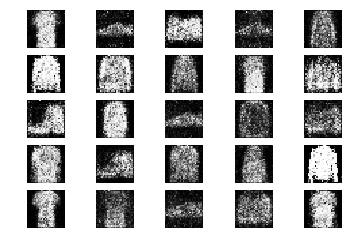

851 [D loss: 0.642490, acc.: 60.94%] [G loss: 0.879451]
852 [D loss: 0.643169, acc.: 56.25%] [G loss: 0.904166]
853 [D loss: 0.591650, acc.: 67.19%] [G loss: 0.882054]
854 [D loss: 0.645653, acc.: 56.25%] [G loss: 0.904915]
855 [D loss: 0.595760, acc.: 73.44%] [G loss: 0.930391]
856 [D loss: 0.618177, acc.: 65.62%] [G loss: 0.850246]
857 [D loss: 0.583235, acc.: 73.44%] [G loss: 0.904020]
858 [D loss: 0.599464, acc.: 62.50%] [G loss: 0.946767]
859 [D loss: 0.563551, acc.: 78.12%] [G loss: 0.852374]
860 [D loss: 0.594342, acc.: 67.19%] [G loss: 1.001304]
861 [D loss: 0.552045, acc.: 70.31%] [G loss: 0.917083]
862 [D loss: 0.590778, acc.: 68.75%] [G loss: 1.001686]
863 [D loss: 0.575106, acc.: 67.19%] [G loss: 0.975449]
864 [D loss: 0.655273, acc.: 56.25%] [G loss: 0.940839]
865 [D loss: 0.604411, acc.: 68.75%] [G loss: 0.979958]
866 [D loss: 0.620923, acc.: 65.62%] [G loss: 0.904426]
867 [D loss: 0.618592, acc.: 65.62%] [G loss: 0.932696]
868 [D loss: 0.621800, acc.: 68.75%] [G loss: 0.

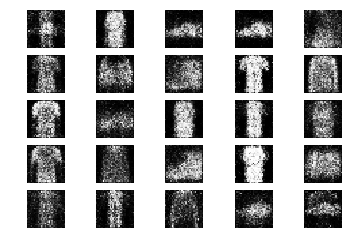

901 [D loss: 0.614099, acc.: 62.50%] [G loss: 1.071548]
902 [D loss: 0.670433, acc.: 64.06%] [G loss: 0.906163]
903 [D loss: 0.616151, acc.: 70.31%] [G loss: 0.913130]
904 [D loss: 0.650550, acc.: 64.06%] [G loss: 0.808421]
905 [D loss: 0.646799, acc.: 56.25%] [G loss: 0.930205]
906 [D loss: 0.584591, acc.: 67.19%] [G loss: 0.944945]
907 [D loss: 0.620192, acc.: 65.62%] [G loss: 1.046379]
908 [D loss: 0.635744, acc.: 65.62%] [G loss: 0.934188]
909 [D loss: 0.644917, acc.: 62.50%] [G loss: 0.776920]
910 [D loss: 0.591091, acc.: 65.62%] [G loss: 0.909199]
911 [D loss: 0.686166, acc.: 56.25%] [G loss: 0.985995]
912 [D loss: 0.561908, acc.: 76.56%] [G loss: 1.044408]
913 [D loss: 0.616553, acc.: 62.50%] [G loss: 0.911797]
914 [D loss: 0.570161, acc.: 70.31%] [G loss: 0.918565]
915 [D loss: 0.620615, acc.: 57.81%] [G loss: 0.854424]
916 [D loss: 0.572356, acc.: 64.06%] [G loss: 0.877316]
917 [D loss: 0.594203, acc.: 75.00%] [G loss: 0.898171]
918 [D loss: 0.655166, acc.: 56.25%] [G loss: 1.

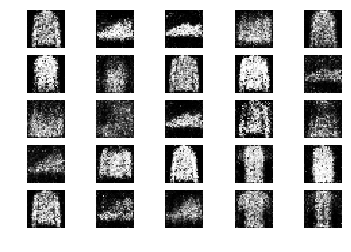

951 [D loss: 0.586876, acc.: 68.75%] [G loss: 0.942760]
952 [D loss: 0.641392, acc.: 62.50%] [G loss: 1.014140]
953 [D loss: 0.609314, acc.: 68.75%] [G loss: 0.904900]
954 [D loss: 0.575867, acc.: 73.44%] [G loss: 1.008083]
955 [D loss: 0.559178, acc.: 70.31%] [G loss: 1.090753]
956 [D loss: 0.665142, acc.: 57.81%] [G loss: 0.970934]
957 [D loss: 0.614554, acc.: 64.06%] [G loss: 0.867697]
958 [D loss: 0.579365, acc.: 68.75%] [G loss: 1.001363]
959 [D loss: 0.632551, acc.: 64.06%] [G loss: 0.910320]
960 [D loss: 0.626400, acc.: 62.50%] [G loss: 0.894964]
961 [D loss: 0.573506, acc.: 68.75%] [G loss: 0.935020]
962 [D loss: 0.596969, acc.: 70.31%] [G loss: 0.991905]
963 [D loss: 0.581704, acc.: 68.75%] [G loss: 0.980519]
964 [D loss: 0.566995, acc.: 71.88%] [G loss: 0.962335]
965 [D loss: 0.606626, acc.: 67.19%] [G loss: 0.968433]
966 [D loss: 0.596137, acc.: 65.62%] [G loss: 0.992766]
967 [D loss: 0.608288, acc.: 67.19%] [G loss: 0.865744]
968 [D loss: 0.617651, acc.: 62.50%] [G loss: 0.

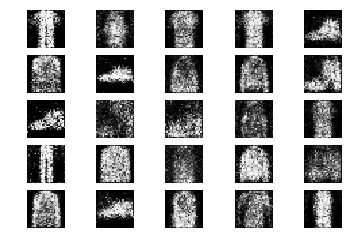

1001 [D loss: 0.552006, acc.: 68.75%] [G loss: 1.080820]
1002 [D loss: 0.670401, acc.: 56.25%] [G loss: 1.038275]
1003 [D loss: 0.622575, acc.: 73.44%] [G loss: 0.972955]
1004 [D loss: 0.561454, acc.: 68.75%] [G loss: 0.919761]
1005 [D loss: 0.622872, acc.: 67.19%] [G loss: 1.046704]
1006 [D loss: 0.588386, acc.: 70.31%] [G loss: 0.961197]
1007 [D loss: 0.642288, acc.: 60.94%] [G loss: 0.894196]
1008 [D loss: 0.645855, acc.: 65.62%] [G loss: 0.969279]
1009 [D loss: 0.646717, acc.: 62.50%] [G loss: 0.881641]
1010 [D loss: 0.625197, acc.: 67.19%] [G loss: 0.968233]
1011 [D loss: 0.553911, acc.: 76.56%] [G loss: 0.911359]
1012 [D loss: 0.580837, acc.: 64.06%] [G loss: 0.980357]
1013 [D loss: 0.603691, acc.: 75.00%] [G loss: 0.994197]
1014 [D loss: 0.659222, acc.: 67.19%] [G loss: 0.887340]
1015 [D loss: 0.683537, acc.: 59.38%] [G loss: 0.914719]
1016 [D loss: 0.611320, acc.: 67.19%] [G loss: 0.933328]
1017 [D loss: 0.675146, acc.: 57.81%] [G loss: 0.891824]
1018 [D loss: 0.693263, acc.: 6

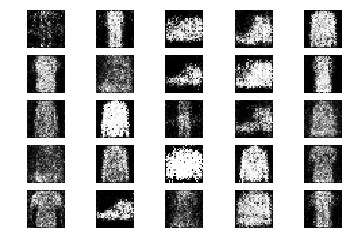

1051 [D loss: 0.664813, acc.: 62.50%] [G loss: 0.780092]
1052 [D loss: 0.613876, acc.: 62.50%] [G loss: 0.887352]
1053 [D loss: 0.588447, acc.: 73.44%] [G loss: 0.944839]
1054 [D loss: 0.654936, acc.: 64.06%] [G loss: 0.875830]
1055 [D loss: 0.658466, acc.: 59.38%] [G loss: 0.926157]
1056 [D loss: 0.608995, acc.: 67.19%] [G loss: 0.760219]
1057 [D loss: 0.657229, acc.: 64.06%] [G loss: 0.849773]
1058 [D loss: 0.635805, acc.: 59.38%] [G loss: 0.905267]
1059 [D loss: 0.625311, acc.: 64.06%] [G loss: 0.873067]
1060 [D loss: 0.636048, acc.: 59.38%] [G loss: 0.892108]
1061 [D loss: 0.625602, acc.: 57.81%] [G loss: 0.902754]
1062 [D loss: 0.615480, acc.: 65.62%] [G loss: 0.909744]
1063 [D loss: 0.668072, acc.: 64.06%] [G loss: 1.021199]
1064 [D loss: 0.652573, acc.: 54.69%] [G loss: 0.923652]
1065 [D loss: 0.640648, acc.: 62.50%] [G loss: 0.912562]
1066 [D loss: 0.627221, acc.: 67.19%] [G loss: 0.915442]
1067 [D loss: 0.624331, acc.: 68.75%] [G loss: 0.889263]
1068 [D loss: 0.585762, acc.: 7

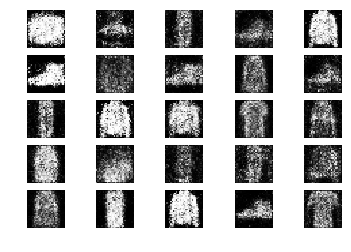

1101 [D loss: 0.578924, acc.: 68.75%] [G loss: 0.893789]
1102 [D loss: 0.603925, acc.: 62.50%] [G loss: 0.957536]
1103 [D loss: 0.582560, acc.: 73.44%] [G loss: 0.983938]
1104 [D loss: 0.638402, acc.: 62.50%] [G loss: 0.984351]
1105 [D loss: 0.638934, acc.: 60.94%] [G loss: 0.987398]
1106 [D loss: 0.707675, acc.: 54.69%] [G loss: 0.850388]
1107 [D loss: 0.621410, acc.: 70.31%] [G loss: 0.989622]
1108 [D loss: 0.591787, acc.: 70.31%] [G loss: 0.917394]
1109 [D loss: 0.634863, acc.: 60.94%] [G loss: 0.838129]
1110 [D loss: 0.648810, acc.: 62.50%] [G loss: 0.966126]
1111 [D loss: 0.617959, acc.: 70.31%] [G loss: 0.923571]
1112 [D loss: 0.577950, acc.: 68.75%] [G loss: 0.848138]
1113 [D loss: 0.696892, acc.: 54.69%] [G loss: 0.856615]
1114 [D loss: 0.655464, acc.: 57.81%] [G loss: 0.926299]
1115 [D loss: 0.606575, acc.: 67.19%] [G loss: 0.864846]
1116 [D loss: 0.659480, acc.: 59.38%] [G loss: 0.796104]
1117 [D loss: 0.617930, acc.: 62.50%] [G loss: 0.958394]
1118 [D loss: 0.608725, acc.: 7

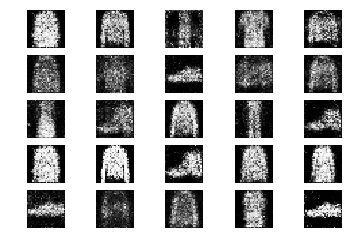

1151 [D loss: 0.558889, acc.: 71.88%] [G loss: 0.951270]
1152 [D loss: 0.608137, acc.: 64.06%] [G loss: 0.950418]
1153 [D loss: 0.601641, acc.: 64.06%] [G loss: 0.922751]
1154 [D loss: 0.623170, acc.: 67.19%] [G loss: 0.920053]
1155 [D loss: 0.567717, acc.: 68.75%] [G loss: 0.936331]
1156 [D loss: 0.643490, acc.: 60.94%] [G loss: 1.065391]
1157 [D loss: 0.645932, acc.: 64.06%] [G loss: 1.011508]
1158 [D loss: 0.646180, acc.: 64.06%] [G loss: 0.905836]
1159 [D loss: 0.556906, acc.: 75.00%] [G loss: 0.836323]
1160 [D loss: 0.580247, acc.: 65.62%] [G loss: 0.969156]
1161 [D loss: 0.598258, acc.: 62.50%] [G loss: 1.048366]
1162 [D loss: 0.628507, acc.: 60.94%] [G loss: 1.021807]
1163 [D loss: 0.569160, acc.: 70.31%] [G loss: 1.008050]
1164 [D loss: 0.635166, acc.: 65.62%] [G loss: 0.966430]
1165 [D loss: 0.602646, acc.: 62.50%] [G loss: 0.962181]
1166 [D loss: 0.688536, acc.: 60.94%] [G loss: 0.981573]
1167 [D loss: 0.644400, acc.: 68.75%] [G loss: 0.983240]
1168 [D loss: 0.581411, acc.: 7

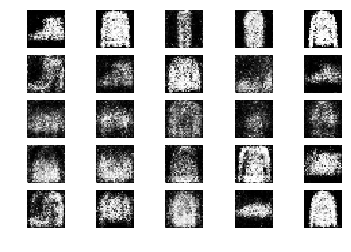

1201 [D loss: 0.599872, acc.: 67.19%] [G loss: 0.958935]
1202 [D loss: 0.616048, acc.: 59.38%] [G loss: 0.934727]
1203 [D loss: 0.641544, acc.: 57.81%] [G loss: 0.962502]
1204 [D loss: 0.559686, acc.: 73.44%] [G loss: 0.969060]
1205 [D loss: 0.664556, acc.: 65.62%] [G loss: 1.054156]
1206 [D loss: 0.612879, acc.: 70.31%] [G loss: 0.930892]
1207 [D loss: 0.647267, acc.: 65.62%] [G loss: 0.943016]
1208 [D loss: 0.557232, acc.: 75.00%] [G loss: 1.014012]
1209 [D loss: 0.572060, acc.: 71.88%] [G loss: 1.045460]
1210 [D loss: 0.652459, acc.: 65.62%] [G loss: 1.062945]
1211 [D loss: 0.578093, acc.: 71.88%] [G loss: 1.048678]
1212 [D loss: 0.569219, acc.: 71.88%] [G loss: 0.954521]
1213 [D loss: 0.682044, acc.: 54.69%] [G loss: 1.047886]
1214 [D loss: 0.623833, acc.: 65.62%] [G loss: 0.994094]
1215 [D loss: 0.623016, acc.: 64.06%] [G loss: 0.941722]
1216 [D loss: 0.581255, acc.: 70.31%] [G loss: 0.898624]
1217 [D loss: 0.628308, acc.: 67.19%] [G loss: 0.907830]
1218 [D loss: 0.609175, acc.: 6

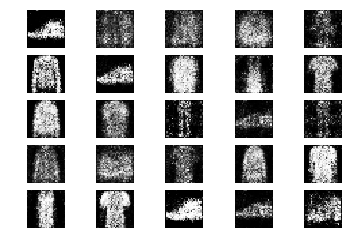

1251 [D loss: 0.581635, acc.: 70.31%] [G loss: 0.873844]
1252 [D loss: 0.622783, acc.: 60.94%] [G loss: 0.940359]
1253 [D loss: 0.648723, acc.: 59.38%] [G loss: 0.963848]
1254 [D loss: 0.681644, acc.: 54.69%] [G loss: 0.927493]
1255 [D loss: 0.595519, acc.: 67.19%] [G loss: 1.022344]
1256 [D loss: 0.599696, acc.: 60.94%] [G loss: 0.880674]
1257 [D loss: 0.571161, acc.: 67.19%] [G loss: 1.004298]
1258 [D loss: 0.616594, acc.: 64.06%] [G loss: 1.027593]
1259 [D loss: 0.716570, acc.: 50.00%] [G loss: 0.991646]
1260 [D loss: 0.552787, acc.: 76.56%] [G loss: 0.977195]
1261 [D loss: 0.535811, acc.: 75.00%] [G loss: 0.924274]
1262 [D loss: 0.576032, acc.: 68.75%] [G loss: 0.920518]
1263 [D loss: 0.657342, acc.: 54.69%] [G loss: 0.914394]
1264 [D loss: 0.617271, acc.: 68.75%] [G loss: 0.929270]
1265 [D loss: 0.554775, acc.: 68.75%] [G loss: 0.915606]
1266 [D loss: 0.574768, acc.: 65.62%] [G loss: 0.899976]
1267 [D loss: 0.530394, acc.: 68.75%] [G loss: 1.067192]
1268 [D loss: 0.635331, acc.: 7

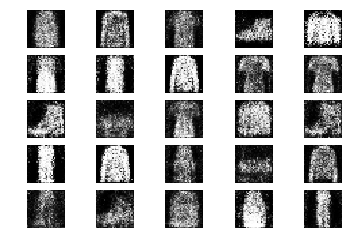

1301 [D loss: 0.624321, acc.: 59.38%] [G loss: 0.875699]
1302 [D loss: 0.624333, acc.: 70.31%] [G loss: 0.978811]
1303 [D loss: 0.608398, acc.: 64.06%] [G loss: 0.954356]
1304 [D loss: 0.616874, acc.: 65.62%] [G loss: 0.924880]
1305 [D loss: 0.608068, acc.: 75.00%] [G loss: 1.032137]
1306 [D loss: 0.620666, acc.: 65.62%] [G loss: 0.931933]
1307 [D loss: 0.604541, acc.: 65.62%] [G loss: 1.041080]
1308 [D loss: 0.641494, acc.: 64.06%] [G loss: 0.942667]
1309 [D loss: 0.570312, acc.: 73.44%] [G loss: 0.856661]
1310 [D loss: 0.610185, acc.: 64.06%] [G loss: 1.023238]
1311 [D loss: 0.578273, acc.: 71.88%] [G loss: 1.035346]
1312 [D loss: 0.603345, acc.: 71.88%] [G loss: 0.978326]
1313 [D loss: 0.647644, acc.: 59.38%] [G loss: 1.031909]
1314 [D loss: 0.618371, acc.: 71.88%] [G loss: 1.073260]
1315 [D loss: 0.608555, acc.: 62.50%] [G loss: 0.950891]
1316 [D loss: 0.617878, acc.: 65.62%] [G loss: 1.135472]
1317 [D loss: 0.609861, acc.: 65.62%] [G loss: 0.970253]
1318 [D loss: 0.657438, acc.: 6

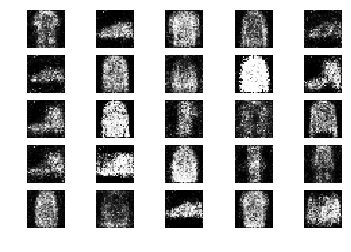

1351 [D loss: 0.594936, acc.: 68.75%] [G loss: 0.960432]
1352 [D loss: 0.627499, acc.: 65.62%] [G loss: 1.001833]
1353 [D loss: 0.650111, acc.: 56.25%] [G loss: 0.867503]
1354 [D loss: 0.575252, acc.: 71.88%] [G loss: 0.992050]
1355 [D loss: 0.667111, acc.: 67.19%] [G loss: 0.944303]
1356 [D loss: 0.599897, acc.: 62.50%] [G loss: 0.943981]
1357 [D loss: 0.532823, acc.: 78.12%] [G loss: 0.968801]
1358 [D loss: 0.515603, acc.: 75.00%] [G loss: 0.953308]
1359 [D loss: 0.621419, acc.: 60.94%] [G loss: 0.993311]
1360 [D loss: 0.687810, acc.: 56.25%] [G loss: 0.931728]
1361 [D loss: 0.614542, acc.: 60.94%] [G loss: 0.987239]
1362 [D loss: 0.573151, acc.: 76.56%] [G loss: 0.900992]
1363 [D loss: 0.569244, acc.: 65.62%] [G loss: 1.107818]
1364 [D loss: 0.579345, acc.: 71.88%] [G loss: 0.956978]
1365 [D loss: 0.587574, acc.: 71.88%] [G loss: 0.991301]
1366 [D loss: 0.658031, acc.: 62.50%] [G loss: 1.085402]
1367 [D loss: 0.577467, acc.: 62.50%] [G loss: 1.115421]
1368 [D loss: 0.618783, acc.: 6

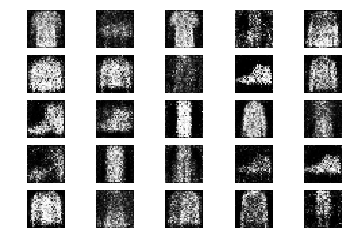

1401 [D loss: 0.631306, acc.: 56.25%] [G loss: 1.016130]
1402 [D loss: 0.606605, acc.: 76.56%] [G loss: 0.950514]
1403 [D loss: 0.615387, acc.: 64.06%] [G loss: 0.942937]
1404 [D loss: 0.603410, acc.: 65.62%] [G loss: 0.952955]
1405 [D loss: 0.611868, acc.: 64.06%] [G loss: 1.018394]
1406 [D loss: 0.551657, acc.: 75.00%] [G loss: 0.926632]
1407 [D loss: 0.657999, acc.: 64.06%] [G loss: 1.090031]
1408 [D loss: 0.637234, acc.: 62.50%] [G loss: 0.915751]
1409 [D loss: 0.633300, acc.: 62.50%] [G loss: 1.048645]
1410 [D loss: 0.659588, acc.: 68.75%] [G loss: 0.899670]
1411 [D loss: 0.643845, acc.: 64.06%] [G loss: 0.957070]
1412 [D loss: 0.641811, acc.: 59.38%] [G loss: 0.906369]
1413 [D loss: 0.658385, acc.: 57.81%] [G loss: 0.805852]
1414 [D loss: 0.626128, acc.: 62.50%] [G loss: 0.920820]
1415 [D loss: 0.593412, acc.: 70.31%] [G loss: 0.917130]
1416 [D loss: 0.546181, acc.: 75.00%] [G loss: 1.043798]
1417 [D loss: 0.636537, acc.: 65.62%] [G loss: 0.928344]
1418 [D loss: 0.601612, acc.: 6

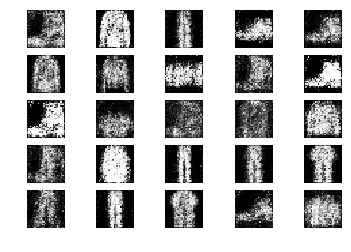

1451 [D loss: 0.582446, acc.: 76.56%] [G loss: 0.964322]
1452 [D loss: 0.557713, acc.: 78.12%] [G loss: 0.961530]
1453 [D loss: 0.650003, acc.: 68.75%] [G loss: 0.914257]
1454 [D loss: 0.641208, acc.: 57.81%] [G loss: 0.911253]
1455 [D loss: 0.573816, acc.: 70.31%] [G loss: 0.984813]
1456 [D loss: 0.609066, acc.: 73.44%] [G loss: 1.075673]
1457 [D loss: 0.586295, acc.: 67.19%] [G loss: 1.035207]
1458 [D loss: 0.584947, acc.: 65.62%] [G loss: 0.856137]
1459 [D loss: 0.584426, acc.: 65.62%] [G loss: 0.911870]
1460 [D loss: 0.557553, acc.: 71.88%] [G loss: 1.049207]
1461 [D loss: 0.630050, acc.: 68.75%] [G loss: 1.020643]
1462 [D loss: 0.622952, acc.: 64.06%] [G loss: 0.965433]
1463 [D loss: 0.578183, acc.: 75.00%] [G loss: 1.033278]
1464 [D loss: 0.590209, acc.: 68.75%] [G loss: 0.946359]
1465 [D loss: 0.606019, acc.: 67.19%] [G loss: 1.001197]
1466 [D loss: 0.618074, acc.: 67.19%] [G loss: 0.948719]
1467 [D loss: 0.582010, acc.: 64.06%] [G loss: 1.094137]
1468 [D loss: 0.611578, acc.: 6

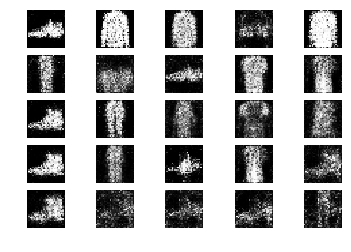

1501 [D loss: 0.626510, acc.: 60.94%] [G loss: 0.959285]
1502 [D loss: 0.587916, acc.: 57.81%] [G loss: 0.861363]
1503 [D loss: 0.617192, acc.: 60.94%] [G loss: 0.959499]
1504 [D loss: 0.598094, acc.: 71.88%] [G loss: 0.955700]
1505 [D loss: 0.683060, acc.: 56.25%] [G loss: 0.904028]
1506 [D loss: 0.563272, acc.: 76.56%] [G loss: 0.991747]
1507 [D loss: 0.564822, acc.: 75.00%] [G loss: 0.831348]
1508 [D loss: 0.644580, acc.: 68.75%] [G loss: 0.836059]
1509 [D loss: 0.608334, acc.: 70.31%] [G loss: 0.865604]
1510 [D loss: 0.531310, acc.: 73.44%] [G loss: 0.861516]
1511 [D loss: 0.655424, acc.: 64.06%] [G loss: 0.965321]
1512 [D loss: 0.644334, acc.: 60.94%] [G loss: 0.988208]
1513 [D loss: 0.617094, acc.: 62.50%] [G loss: 0.931641]
1514 [D loss: 0.635871, acc.: 62.50%] [G loss: 0.996778]
1515 [D loss: 0.515901, acc.: 79.69%] [G loss: 0.994353]
1516 [D loss: 0.599553, acc.: 65.62%] [G loss: 1.124415]
1517 [D loss: 0.680670, acc.: 51.56%] [G loss: 1.012190]
1518 [D loss: 0.496783, acc.: 7

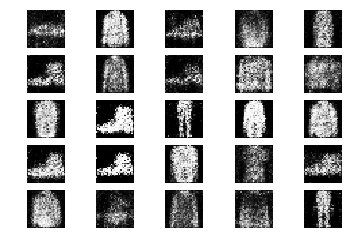

1551 [D loss: 0.598755, acc.: 70.31%] [G loss: 0.850990]
1552 [D loss: 0.626963, acc.: 64.06%] [G loss: 1.013692]
1553 [D loss: 0.584874, acc.: 67.19%] [G loss: 1.054282]
1554 [D loss: 0.603824, acc.: 64.06%] [G loss: 0.959533]
1555 [D loss: 0.628003, acc.: 62.50%] [G loss: 0.894875]
1556 [D loss: 0.648297, acc.: 62.50%] [G loss: 0.895285]
1557 [D loss: 0.576921, acc.: 67.19%] [G loss: 0.897818]
1558 [D loss: 0.582183, acc.: 73.44%] [G loss: 1.014663]
1559 [D loss: 0.670420, acc.: 62.50%] [G loss: 0.985750]
1560 [D loss: 0.626658, acc.: 62.50%] [G loss: 0.987262]
1561 [D loss: 0.640848, acc.: 60.94%] [G loss: 1.000439]
1562 [D loss: 0.691079, acc.: 57.81%] [G loss: 0.898300]
1563 [D loss: 0.632064, acc.: 57.81%] [G loss: 0.923119]
1564 [D loss: 0.628108, acc.: 70.31%] [G loss: 1.022795]
1565 [D loss: 0.656833, acc.: 64.06%] [G loss: 0.991125]
1566 [D loss: 0.640000, acc.: 57.81%] [G loss: 1.019227]
1567 [D loss: 0.637354, acc.: 62.50%] [G loss: 0.953673]
1568 [D loss: 0.585293, acc.: 7

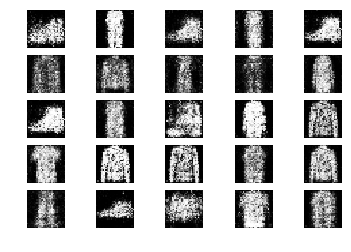

1601 [D loss: 0.561398, acc.: 73.44%] [G loss: 0.934928]
1602 [D loss: 0.611413, acc.: 65.62%] [G loss: 0.935463]
1603 [D loss: 0.681689, acc.: 60.94%] [G loss: 0.968034]
1604 [D loss: 0.554107, acc.: 67.19%] [G loss: 0.971207]
1605 [D loss: 0.618702, acc.: 62.50%] [G loss: 1.037805]
1606 [D loss: 0.580639, acc.: 71.88%] [G loss: 1.007179]
1607 [D loss: 0.605064, acc.: 68.75%] [G loss: 0.988693]
1608 [D loss: 0.524078, acc.: 84.38%] [G loss: 0.941074]
1609 [D loss: 0.577818, acc.: 67.19%] [G loss: 0.984107]
1610 [D loss: 0.558740, acc.: 65.62%] [G loss: 1.118056]
1611 [D loss: 0.611601, acc.: 64.06%] [G loss: 0.971641]
1612 [D loss: 0.621688, acc.: 67.19%] [G loss: 0.924475]
1613 [D loss: 0.586901, acc.: 62.50%] [G loss: 0.950856]
1614 [D loss: 0.728563, acc.: 51.56%] [G loss: 0.911504]
1615 [D loss: 0.616845, acc.: 62.50%] [G loss: 0.946979]
1616 [D loss: 0.603953, acc.: 71.88%] [G loss: 0.949468]
1617 [D loss: 0.679360, acc.: 57.81%] [G loss: 0.979165]
1618 [D loss: 0.580034, acc.: 6

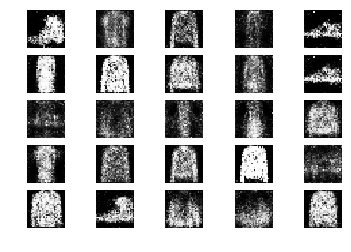

1651 [D loss: 0.542041, acc.: 76.56%] [G loss: 0.950539]
1652 [D loss: 0.602619, acc.: 68.75%] [G loss: 1.016155]
1653 [D loss: 0.521885, acc.: 78.12%] [G loss: 0.930806]
1654 [D loss: 0.563505, acc.: 73.44%] [G loss: 0.957596]
1655 [D loss: 0.632031, acc.: 70.31%] [G loss: 0.919062]
1656 [D loss: 0.464543, acc.: 79.69%] [G loss: 0.948025]
1657 [D loss: 0.618669, acc.: 64.06%] [G loss: 0.929485]
1658 [D loss: 0.570352, acc.: 71.88%] [G loss: 1.042469]
1659 [D loss: 0.669802, acc.: 59.38%] [G loss: 1.018763]
1660 [D loss: 0.656269, acc.: 67.19%] [G loss: 1.002244]
1661 [D loss: 0.554159, acc.: 73.44%] [G loss: 1.038233]
1662 [D loss: 0.726164, acc.: 56.25%] [G loss: 0.933294]
1663 [D loss: 0.569229, acc.: 75.00%] [G loss: 0.935754]
1664 [D loss: 0.598340, acc.: 67.19%] [G loss: 0.906100]
1665 [D loss: 0.649472, acc.: 65.62%] [G loss: 0.974002]
1666 [D loss: 0.615424, acc.: 62.50%] [G loss: 0.862205]
1667 [D loss: 0.599010, acc.: 65.62%] [G loss: 0.960192]
1668 [D loss: 0.660263, acc.: 6

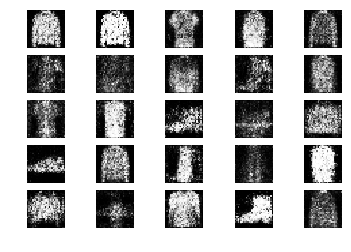

1701 [D loss: 0.649052, acc.: 68.75%] [G loss: 0.965451]
1702 [D loss: 0.586242, acc.: 67.19%] [G loss: 0.947954]
1703 [D loss: 0.640071, acc.: 60.94%] [G loss: 0.966643]
1704 [D loss: 0.584092, acc.: 70.31%] [G loss: 1.000900]
1705 [D loss: 0.678255, acc.: 64.06%] [G loss: 1.008116]
1706 [D loss: 0.562747, acc.: 68.75%] [G loss: 1.042525]
1707 [D loss: 0.621930, acc.: 64.06%] [G loss: 0.959085]
1708 [D loss: 0.590357, acc.: 70.31%] [G loss: 1.113891]
1709 [D loss: 0.655276, acc.: 65.62%] [G loss: 0.973223]
1710 [D loss: 0.599064, acc.: 67.19%] [G loss: 1.019399]
1711 [D loss: 0.671623, acc.: 59.38%] [G loss: 1.018702]
1712 [D loss: 0.630659, acc.: 62.50%] [G loss: 1.044090]
1713 [D loss: 0.562521, acc.: 71.88%] [G loss: 1.015001]
1714 [D loss: 0.583517, acc.: 71.88%] [G loss: 1.069661]
1715 [D loss: 0.534901, acc.: 71.88%] [G loss: 1.006679]
1716 [D loss: 0.668097, acc.: 64.06%] [G loss: 0.946784]
1717 [D loss: 0.551591, acc.: 76.56%] [G loss: 0.933165]
1718 [D loss: 0.675913, acc.: 5

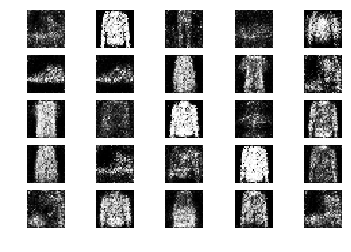

1751 [D loss: 0.596040, acc.: 67.19%] [G loss: 1.073132]
1752 [D loss: 0.624533, acc.: 60.94%] [G loss: 1.069893]
1753 [D loss: 0.625027, acc.: 64.06%] [G loss: 1.049188]
1754 [D loss: 0.724765, acc.: 46.88%] [G loss: 0.991366]
1755 [D loss: 0.592348, acc.: 65.62%] [G loss: 0.945061]
1756 [D loss: 0.646508, acc.: 59.38%] [G loss: 0.944550]
1757 [D loss: 0.647932, acc.: 60.94%] [G loss: 1.009912]
1758 [D loss: 0.598354, acc.: 73.44%] [G loss: 1.037055]
1759 [D loss: 0.656757, acc.: 64.06%] [G loss: 0.996338]
1760 [D loss: 0.602034, acc.: 75.00%] [G loss: 0.966320]
1761 [D loss: 0.596658, acc.: 65.62%] [G loss: 0.955653]
1762 [D loss: 0.645584, acc.: 57.81%] [G loss: 0.914028]
1763 [D loss: 0.619386, acc.: 59.38%] [G loss: 1.084699]
1764 [D loss: 0.682034, acc.: 54.69%] [G loss: 0.900375]
1765 [D loss: 0.637100, acc.: 64.06%] [G loss: 0.943624]
1766 [D loss: 0.605781, acc.: 68.75%] [G loss: 0.937537]
1767 [D loss: 0.577293, acc.: 70.31%] [G loss: 0.925306]
1768 [D loss: 0.678258, acc.: 6

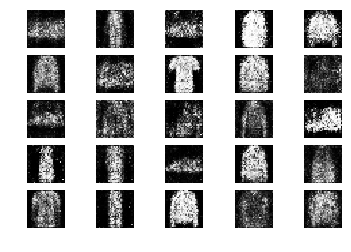

1801 [D loss: 0.545288, acc.: 76.56%] [G loss: 0.883347]
1802 [D loss: 0.606438, acc.: 60.94%] [G loss: 0.898248]
1803 [D loss: 0.564658, acc.: 67.19%] [G loss: 0.808624]
1804 [D loss: 0.624534, acc.: 70.31%] [G loss: 0.918230]
1805 [D loss: 0.684572, acc.: 51.56%] [G loss: 0.906247]
1806 [D loss: 0.611099, acc.: 62.50%] [G loss: 0.983978]
1807 [D loss: 0.588552, acc.: 75.00%] [G loss: 0.946784]
1808 [D loss: 0.525239, acc.: 76.56%] [G loss: 0.998569]
1809 [D loss: 0.549446, acc.: 78.12%] [G loss: 1.009378]
1810 [D loss: 0.626467, acc.: 68.75%] [G loss: 1.003393]
1811 [D loss: 0.547218, acc.: 67.19%] [G loss: 1.040078]
1812 [D loss: 0.620420, acc.: 68.75%] [G loss: 1.055448]
1813 [D loss: 0.586436, acc.: 70.31%] [G loss: 1.018143]
1814 [D loss: 0.634058, acc.: 62.50%] [G loss: 0.941243]
1815 [D loss: 0.693231, acc.: 53.12%] [G loss: 0.984751]
1816 [D loss: 0.627137, acc.: 56.25%] [G loss: 0.877056]
1817 [D loss: 0.625977, acc.: 67.19%] [G loss: 0.857830]
1818 [D loss: 0.622552, acc.: 6

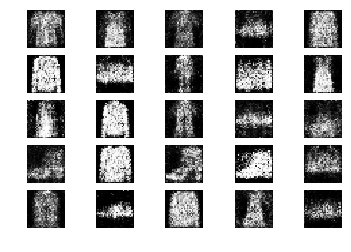

1851 [D loss: 0.625540, acc.: 68.75%] [G loss: 0.976590]
1852 [D loss: 0.726423, acc.: 54.69%] [G loss: 1.003671]
1853 [D loss: 0.587606, acc.: 68.75%] [G loss: 0.969839]
1854 [D loss: 0.592671, acc.: 67.19%] [G loss: 1.008098]
1855 [D loss: 0.630424, acc.: 73.44%] [G loss: 1.003382]
1856 [D loss: 0.595921, acc.: 68.75%] [G loss: 0.973929]
1857 [D loss: 0.659013, acc.: 60.94%] [G loss: 0.875409]
1858 [D loss: 0.612553, acc.: 62.50%] [G loss: 0.866487]
1859 [D loss: 0.519008, acc.: 75.00%] [G loss: 0.898998]
1860 [D loss: 0.622213, acc.: 60.94%] [G loss: 0.959648]
1861 [D loss: 0.629506, acc.: 64.06%] [G loss: 0.971102]
1862 [D loss: 0.661930, acc.: 65.62%] [G loss: 0.989885]
1863 [D loss: 0.567234, acc.: 71.88%] [G loss: 0.987928]
1864 [D loss: 0.638141, acc.: 59.38%] [G loss: 0.971912]
1865 [D loss: 0.547442, acc.: 76.56%] [G loss: 0.973695]
1866 [D loss: 0.701747, acc.: 53.12%] [G loss: 1.022458]
1867 [D loss: 0.589287, acc.: 68.75%] [G loss: 0.927320]
1868 [D loss: 0.575043, acc.: 6

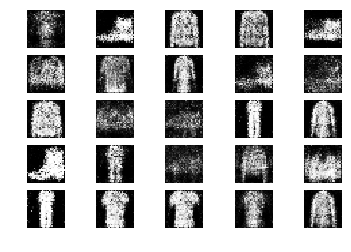

1901 [D loss: 0.654761, acc.: 62.50%] [G loss: 1.065256]
1902 [D loss: 0.667758, acc.: 57.81%] [G loss: 0.970552]
1903 [D loss: 0.615486, acc.: 73.44%] [G loss: 0.953014]
1904 [D loss: 0.649999, acc.: 64.06%] [G loss: 0.913702]
1905 [D loss: 0.681178, acc.: 59.38%] [G loss: 0.815999]
1906 [D loss: 0.621327, acc.: 60.94%] [G loss: 0.870106]
1907 [D loss: 0.618811, acc.: 62.50%] [G loss: 0.836375]
1908 [D loss: 0.631978, acc.: 62.50%] [G loss: 0.928883]
1909 [D loss: 0.584761, acc.: 68.75%] [G loss: 0.832545]
1910 [D loss: 0.540144, acc.: 70.31%] [G loss: 0.983014]
1911 [D loss: 0.682324, acc.: 67.19%] [G loss: 1.064452]
1912 [D loss: 0.607137, acc.: 65.62%] [G loss: 1.131760]
1913 [D loss: 0.736277, acc.: 53.12%] [G loss: 0.932622]
1914 [D loss: 0.645042, acc.: 64.06%] [G loss: 0.918500]
1915 [D loss: 0.609366, acc.: 67.19%] [G loss: 0.898904]
1916 [D loss: 0.602838, acc.: 64.06%] [G loss: 0.964039]
1917 [D loss: 0.628177, acc.: 65.62%] [G loss: 0.932319]
1918 [D loss: 0.593884, acc.: 7

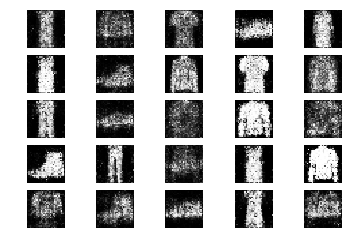

1951 [D loss: 0.566990, acc.: 75.00%] [G loss: 0.961411]
1952 [D loss: 0.621332, acc.: 65.62%] [G loss: 1.012503]
1953 [D loss: 0.622554, acc.: 62.50%] [G loss: 1.014040]
1954 [D loss: 0.536937, acc.: 73.44%] [G loss: 1.110906]
1955 [D loss: 0.659598, acc.: 64.06%] [G loss: 0.969068]
1956 [D loss: 0.572499, acc.: 67.19%] [G loss: 0.940630]
1957 [D loss: 0.626533, acc.: 64.06%] [G loss: 1.048744]
1958 [D loss: 0.594665, acc.: 67.19%] [G loss: 1.031719]
1959 [D loss: 0.616433, acc.: 59.38%] [G loss: 1.050355]
1960 [D loss: 0.668315, acc.: 64.06%] [G loss: 1.070911]
1961 [D loss: 0.560969, acc.: 79.69%] [G loss: 1.028135]
1962 [D loss: 0.633003, acc.: 59.38%] [G loss: 0.894702]
1963 [D loss: 0.581487, acc.: 71.88%] [G loss: 0.818562]
1964 [D loss: 0.596610, acc.: 67.19%] [G loss: 0.913960]
1965 [D loss: 0.581030, acc.: 68.75%] [G loss: 0.947022]
1966 [D loss: 0.575933, acc.: 75.00%] [G loss: 0.930215]
1967 [D loss: 0.693825, acc.: 57.81%] [G loss: 1.067138]
1968 [D loss: 0.578189, acc.: 6

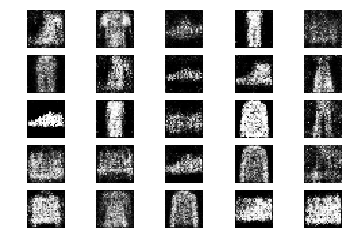

2001 [D loss: 0.625460, acc.: 70.31%] [G loss: 0.994573]
2002 [D loss: 0.599480, acc.: 68.75%] [G loss: 0.973575]
2003 [D loss: 0.626691, acc.: 65.62%] [G loss: 1.004643]
2004 [D loss: 0.605242, acc.: 68.75%] [G loss: 1.010632]
2005 [D loss: 0.649196, acc.: 65.62%] [G loss: 0.945520]
2006 [D loss: 0.693947, acc.: 60.94%] [G loss: 1.085978]
2007 [D loss: 0.652493, acc.: 56.25%] [G loss: 0.973121]
2008 [D loss: 0.556469, acc.: 73.44%] [G loss: 0.949113]
2009 [D loss: 0.620022, acc.: 59.38%] [G loss: 0.929018]
2010 [D loss: 0.586692, acc.: 73.44%] [G loss: 1.004545]
2011 [D loss: 0.604944, acc.: 68.75%] [G loss: 0.951100]
2012 [D loss: 0.741432, acc.: 56.25%] [G loss: 0.963737]
2013 [D loss: 0.665070, acc.: 59.38%] [G loss: 0.930789]
2014 [D loss: 0.595644, acc.: 59.38%] [G loss: 0.930398]
2015 [D loss: 0.644186, acc.: 57.81%] [G loss: 0.978231]
2016 [D loss: 0.630857, acc.: 67.19%] [G loss: 0.903673]
2017 [D loss: 0.611675, acc.: 64.06%] [G loss: 0.863297]
2018 [D loss: 0.674682, acc.: 5

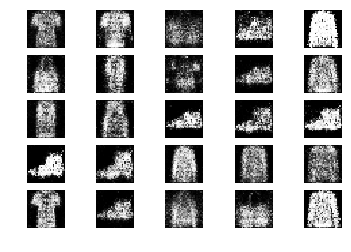

2051 [D loss: 0.609658, acc.: 70.31%] [G loss: 1.030996]
2052 [D loss: 0.605775, acc.: 70.31%] [G loss: 1.065539]
2053 [D loss: 0.595557, acc.: 64.06%] [G loss: 0.966327]
2054 [D loss: 0.617919, acc.: 68.75%] [G loss: 0.977459]
2055 [D loss: 0.629278, acc.: 59.38%] [G loss: 1.090386]
2056 [D loss: 0.571016, acc.: 73.44%] [G loss: 0.956220]
2057 [D loss: 0.573132, acc.: 71.88%] [G loss: 0.972532]
2058 [D loss: 0.553140, acc.: 68.75%] [G loss: 0.885116]
2059 [D loss: 0.689004, acc.: 51.56%] [G loss: 0.917344]
2060 [D loss: 0.643985, acc.: 56.25%] [G loss: 1.003844]
2061 [D loss: 0.648889, acc.: 57.81%] [G loss: 0.904142]
2062 [D loss: 0.646105, acc.: 60.94%] [G loss: 0.997669]
2063 [D loss: 0.617514, acc.: 70.31%] [G loss: 1.010710]
2064 [D loss: 0.633436, acc.: 64.06%] [G loss: 0.994352]
2065 [D loss: 0.600660, acc.: 71.88%] [G loss: 0.935190]
2066 [D loss: 0.614495, acc.: 68.75%] [G loss: 1.059207]
2067 [D loss: 0.672246, acc.: 50.00%] [G loss: 1.117956]
2068 [D loss: 0.608552, acc.: 6

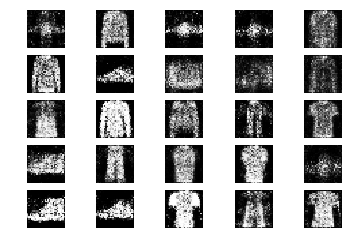

2101 [D loss: 0.664422, acc.: 56.25%] [G loss: 0.941899]
2102 [D loss: 0.661860, acc.: 65.62%] [G loss: 0.984784]
2103 [D loss: 0.621806, acc.: 64.06%] [G loss: 0.856060]
2104 [D loss: 0.654079, acc.: 60.94%] [G loss: 1.013598]
2105 [D loss: 0.614377, acc.: 65.62%] [G loss: 0.941945]
2106 [D loss: 0.577197, acc.: 73.44%] [G loss: 1.000832]
2107 [D loss: 0.598144, acc.: 68.75%] [G loss: 0.986127]
2108 [D loss: 0.601997, acc.: 67.19%] [G loss: 0.893392]
2109 [D loss: 0.621517, acc.: 57.81%] [G loss: 0.954443]
2110 [D loss: 0.584472, acc.: 73.44%] [G loss: 0.923615]
2111 [D loss: 0.660091, acc.: 60.94%] [G loss: 0.967281]
2112 [D loss: 0.624346, acc.: 64.06%] [G loss: 0.978997]
2113 [D loss: 0.614933, acc.: 62.50%] [G loss: 0.934070]
2114 [D loss: 0.609844, acc.: 62.50%] [G loss: 0.979644]
2115 [D loss: 0.688070, acc.: 64.06%] [G loss: 0.856897]
2116 [D loss: 0.689183, acc.: 54.69%] [G loss: 0.987194]
2117 [D loss: 0.574418, acc.: 68.75%] [G loss: 0.880638]
2118 [D loss: 0.668144, acc.: 5

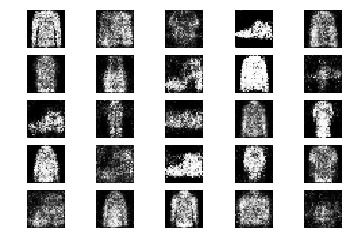

2151 [D loss: 0.659911, acc.: 60.94%] [G loss: 0.944390]
2152 [D loss: 0.606013, acc.: 68.75%] [G loss: 0.871317]
2153 [D loss: 0.636380, acc.: 67.19%] [G loss: 0.949030]
2154 [D loss: 0.573352, acc.: 75.00%] [G loss: 0.963389]
2155 [D loss: 0.652530, acc.: 57.81%] [G loss: 1.037250]
2156 [D loss: 0.623990, acc.: 65.62%] [G loss: 0.960979]
2157 [D loss: 0.640864, acc.: 62.50%] [G loss: 0.991148]
2158 [D loss: 0.651646, acc.: 65.62%] [G loss: 0.945348]
2159 [D loss: 0.597092, acc.: 76.56%] [G loss: 0.958560]
2160 [D loss: 0.595333, acc.: 65.62%] [G loss: 1.041973]
2161 [D loss: 0.641855, acc.: 59.38%] [G loss: 1.028233]
2162 [D loss: 0.608813, acc.: 68.75%] [G loss: 0.922323]
2163 [D loss: 0.659177, acc.: 59.38%] [G loss: 0.993438]
2164 [D loss: 0.678670, acc.: 60.94%] [G loss: 0.869777]
2165 [D loss: 0.610509, acc.: 65.62%] [G loss: 0.887723]
2166 [D loss: 0.628242, acc.: 64.06%] [G loss: 0.921206]
2167 [D loss: 0.560371, acc.: 76.56%] [G loss: 0.921986]
2168 [D loss: 0.635199, acc.: 6

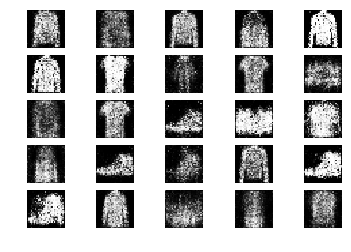

2201 [D loss: 0.617767, acc.: 70.31%] [G loss: 0.845718]
2202 [D loss: 0.620000, acc.: 73.44%] [G loss: 1.001525]
2203 [D loss: 0.624418, acc.: 70.31%] [G loss: 0.900186]
2204 [D loss: 0.556159, acc.: 73.44%] [G loss: 0.949930]
2205 [D loss: 0.651442, acc.: 59.38%] [G loss: 0.964583]
2206 [D loss: 0.626972, acc.: 65.62%] [G loss: 0.913131]
2207 [D loss: 0.615242, acc.: 68.75%] [G loss: 0.929182]
2208 [D loss: 0.655407, acc.: 57.81%] [G loss: 0.967278]
2209 [D loss: 0.645555, acc.: 59.38%] [G loss: 0.951998]
2210 [D loss: 0.700632, acc.: 57.81%] [G loss: 0.935188]
2211 [D loss: 0.536275, acc.: 73.44%] [G loss: 0.894421]
2212 [D loss: 0.614018, acc.: 64.06%] [G loss: 0.965713]
2213 [D loss: 0.681987, acc.: 46.88%] [G loss: 0.966872]
2214 [D loss: 0.620520, acc.: 59.38%] [G loss: 0.888794]
2215 [D loss: 0.613610, acc.: 64.06%] [G loss: 0.853535]
2216 [D loss: 0.616918, acc.: 65.62%] [G loss: 0.975922]
2217 [D loss: 0.613424, acc.: 65.62%] [G loss: 0.922351]
2218 [D loss: 0.626922, acc.: 6

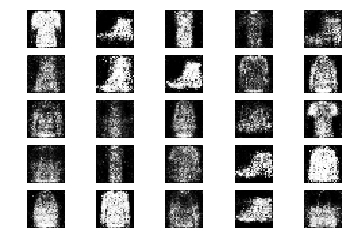

2251 [D loss: 0.624103, acc.: 60.94%] [G loss: 0.974081]
2252 [D loss: 0.562975, acc.: 68.75%] [G loss: 0.868535]
2253 [D loss: 0.650887, acc.: 60.94%] [G loss: 1.017758]
2254 [D loss: 0.622769, acc.: 67.19%] [G loss: 0.991818]
2255 [D loss: 0.701037, acc.: 57.81%] [G loss: 0.909778]
2256 [D loss: 0.550630, acc.: 76.56%] [G loss: 0.949925]
2257 [D loss: 0.660621, acc.: 59.38%] [G loss: 0.886465]
2258 [D loss: 0.698928, acc.: 56.25%] [G loss: 0.886953]
2259 [D loss: 0.655440, acc.: 60.94%] [G loss: 0.816309]
2260 [D loss: 0.642817, acc.: 59.38%] [G loss: 0.928110]
2261 [D loss: 0.651813, acc.: 57.81%] [G loss: 1.015388]
2262 [D loss: 0.607613, acc.: 64.06%] [G loss: 0.969656]
2263 [D loss: 0.639874, acc.: 62.50%] [G loss: 1.007410]
2264 [D loss: 0.612449, acc.: 64.06%] [G loss: 0.962123]
2265 [D loss: 0.645777, acc.: 59.38%] [G loss: 0.983271]
2266 [D loss: 0.634196, acc.: 56.25%] [G loss: 0.930396]
2267 [D loss: 0.602025, acc.: 73.44%] [G loss: 1.053112]
2268 [D loss: 0.628101, acc.: 7

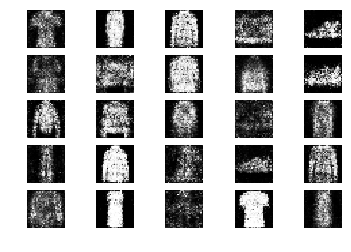

2301 [D loss: 0.632874, acc.: 59.38%] [G loss: 0.981658]
2302 [D loss: 0.541050, acc.: 71.88%] [G loss: 1.003220]
2303 [D loss: 0.574894, acc.: 70.31%] [G loss: 0.996448]
2304 [D loss: 0.684360, acc.: 57.81%] [G loss: 0.982622]
2305 [D loss: 0.623564, acc.: 60.94%] [G loss: 0.970623]
2306 [D loss: 0.640047, acc.: 62.50%] [G loss: 0.867743]
2307 [D loss: 0.597176, acc.: 70.31%] [G loss: 0.816514]
2308 [D loss: 0.589200, acc.: 71.88%] [G loss: 0.994959]
2309 [D loss: 0.635909, acc.: 64.06%] [G loss: 0.971749]
2310 [D loss: 0.670158, acc.: 57.81%] [G loss: 0.926409]
2311 [D loss: 0.583980, acc.: 71.88%] [G loss: 0.949463]
2312 [D loss: 0.683731, acc.: 54.69%] [G loss: 0.880475]
2313 [D loss: 0.618688, acc.: 59.38%] [G loss: 0.978151]
2314 [D loss: 0.606081, acc.: 71.88%] [G loss: 1.023438]
2315 [D loss: 0.690983, acc.: 51.56%] [G loss: 0.869082]
2316 [D loss: 0.649311, acc.: 57.81%] [G loss: 0.895285]
2317 [D loss: 0.644330, acc.: 64.06%] [G loss: 0.989535]
2318 [D loss: 0.600872, acc.: 6

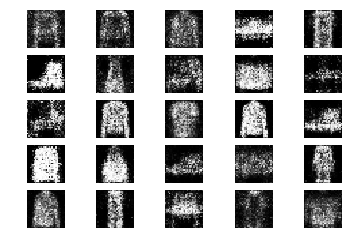

2351 [D loss: 0.583199, acc.: 76.56%] [G loss: 0.975791]
2352 [D loss: 0.666672, acc.: 64.06%] [G loss: 0.947378]
2353 [D loss: 0.589688, acc.: 65.62%] [G loss: 0.966027]
2354 [D loss: 0.588240, acc.: 68.75%] [G loss: 0.956837]
2355 [D loss: 0.637717, acc.: 62.50%] [G loss: 0.909133]
2356 [D loss: 0.619298, acc.: 65.62%] [G loss: 0.860661]
2357 [D loss: 0.633919, acc.: 62.50%] [G loss: 0.952405]
2358 [D loss: 0.550822, acc.: 76.56%] [G loss: 1.065749]
2359 [D loss: 0.614704, acc.: 64.06%] [G loss: 0.962799]
2360 [D loss: 0.602615, acc.: 65.62%] [G loss: 0.829967]
2361 [D loss: 0.608541, acc.: 67.19%] [G loss: 0.877578]
2362 [D loss: 0.614618, acc.: 62.50%] [G loss: 0.871915]
2363 [D loss: 0.612560, acc.: 62.50%] [G loss: 0.847813]
2364 [D loss: 0.662268, acc.: 56.25%] [G loss: 0.869344]
2365 [D loss: 0.699476, acc.: 65.62%] [G loss: 0.970027]
2366 [D loss: 0.539104, acc.: 71.88%] [G loss: 1.009169]
2367 [D loss: 0.605942, acc.: 67.19%] [G loss: 1.052311]
2368 [D loss: 0.622452, acc.: 6

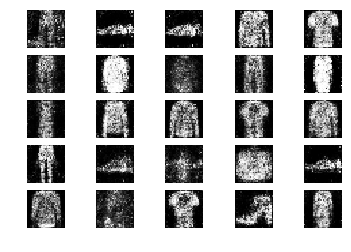

2401 [D loss: 0.649064, acc.: 62.50%] [G loss: 0.991225]
2402 [D loss: 0.635297, acc.: 56.25%] [G loss: 0.995502]
2403 [D loss: 0.584279, acc.: 70.31%] [G loss: 0.933282]
2404 [D loss: 0.628629, acc.: 59.38%] [G loss: 0.936633]
2405 [D loss: 0.611799, acc.: 59.38%] [G loss: 0.923319]
2406 [D loss: 0.577685, acc.: 71.88%] [G loss: 1.005886]
2407 [D loss: 0.712544, acc.: 57.81%] [G loss: 0.994589]
2408 [D loss: 0.630148, acc.: 67.19%] [G loss: 0.977624]
2409 [D loss: 0.584638, acc.: 71.88%] [G loss: 0.945082]
2410 [D loss: 0.606271, acc.: 65.62%] [G loss: 0.889622]
2411 [D loss: 0.647773, acc.: 62.50%] [G loss: 0.929526]
2412 [D loss: 0.626821, acc.: 67.19%] [G loss: 0.958369]
2413 [D loss: 0.628203, acc.: 60.94%] [G loss: 0.982888]
2414 [D loss: 0.568654, acc.: 73.44%] [G loss: 1.032368]
2415 [D loss: 0.677879, acc.: 60.94%] [G loss: 1.009628]
2416 [D loss: 0.629244, acc.: 65.62%] [G loss: 1.030410]
2417 [D loss: 0.573960, acc.: 65.62%] [G loss: 0.983389]
2418 [D loss: 0.640499, acc.: 6

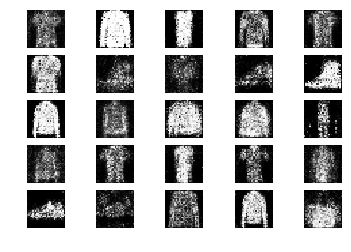

2451 [D loss: 0.590201, acc.: 60.94%] [G loss: 0.932601]
2452 [D loss: 0.622867, acc.: 59.38%] [G loss: 0.874611]
2453 [D loss: 0.607860, acc.: 71.88%] [G loss: 0.910744]
2454 [D loss: 0.609399, acc.: 56.25%] [G loss: 1.038284]
2455 [D loss: 0.677695, acc.: 54.69%] [G loss: 0.937586]
2456 [D loss: 0.592005, acc.: 73.44%] [G loss: 0.937940]
2457 [D loss: 0.733785, acc.: 56.25%] [G loss: 0.987189]
2458 [D loss: 0.632364, acc.: 62.50%] [G loss: 1.018368]
2459 [D loss: 0.647854, acc.: 56.25%] [G loss: 0.921511]
2460 [D loss: 0.754627, acc.: 53.12%] [G loss: 0.947385]
2461 [D loss: 0.642385, acc.: 64.06%] [G loss: 0.998790]
2462 [D loss: 0.641477, acc.: 62.50%] [G loss: 1.014887]
2463 [D loss: 0.653195, acc.: 56.25%] [G loss: 1.022807]
2464 [D loss: 0.645997, acc.: 65.62%] [G loss: 1.014531]
2465 [D loss: 0.571835, acc.: 75.00%] [G loss: 0.904736]
2466 [D loss: 0.648427, acc.: 59.38%] [G loss: 0.899119]
2467 [D loss: 0.681887, acc.: 54.69%] [G loss: 0.967139]
2468 [D loss: 0.571039, acc.: 7

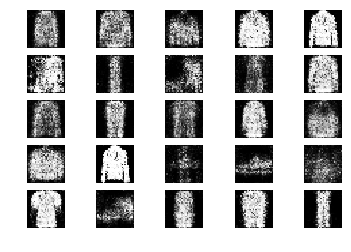

2501 [D loss: 0.633376, acc.: 56.25%] [G loss: 0.888732]
2502 [D loss: 0.562903, acc.: 64.06%] [G loss: 1.010008]
2503 [D loss: 0.672110, acc.: 68.75%] [G loss: 0.927970]
2504 [D loss: 0.688309, acc.: 64.06%] [G loss: 0.899602]
2505 [D loss: 0.638201, acc.: 65.62%] [G loss: 0.867718]
2506 [D loss: 0.609045, acc.: 67.19%] [G loss: 0.869774]
2507 [D loss: 0.674167, acc.: 60.94%] [G loss: 0.931637]
2508 [D loss: 0.660093, acc.: 64.06%] [G loss: 0.941093]
2509 [D loss: 0.616831, acc.: 60.94%] [G loss: 1.078446]
2510 [D loss: 0.592529, acc.: 68.75%] [G loss: 1.034982]
2511 [D loss: 0.616845, acc.: 62.50%] [G loss: 1.056006]
2512 [D loss: 0.592224, acc.: 68.75%] [G loss: 1.070380]
2513 [D loss: 0.627519, acc.: 67.19%] [G loss: 1.033723]
2514 [D loss: 0.594084, acc.: 60.94%] [G loss: 0.934426]
2515 [D loss: 0.678140, acc.: 57.81%] [G loss: 0.855701]
2516 [D loss: 0.653055, acc.: 60.94%] [G loss: 0.882053]
2517 [D loss: 0.570151, acc.: 73.44%] [G loss: 0.980600]
2518 [D loss: 0.653513, acc.: 6

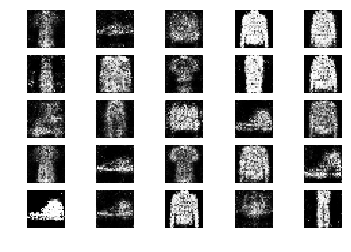

2551 [D loss: 0.666745, acc.: 56.25%] [G loss: 0.980609]
2552 [D loss: 0.641038, acc.: 56.25%] [G loss: 0.888469]
2553 [D loss: 0.728356, acc.: 59.38%] [G loss: 0.908849]
2554 [D loss: 0.560757, acc.: 76.56%] [G loss: 1.048407]
2555 [D loss: 0.682739, acc.: 53.12%] [G loss: 0.996690]
2556 [D loss: 0.630690, acc.: 59.38%] [G loss: 0.989322]
2557 [D loss: 0.613026, acc.: 68.75%] [G loss: 1.004880]
2558 [D loss: 0.648041, acc.: 64.06%] [G loss: 0.960297]
2559 [D loss: 0.659703, acc.: 54.69%] [G loss: 0.933883]
2560 [D loss: 0.686765, acc.: 54.69%] [G loss: 0.927326]
2561 [D loss: 0.683399, acc.: 57.81%] [G loss: 1.012376]
2562 [D loss: 0.656444, acc.: 62.50%] [G loss: 0.897159]
2563 [D loss: 0.599694, acc.: 70.31%] [G loss: 0.956865]
2564 [D loss: 0.659864, acc.: 62.50%] [G loss: 1.011654]
2565 [D loss: 0.540342, acc.: 79.69%] [G loss: 0.934024]
2566 [D loss: 0.581745, acc.: 70.31%] [G loss: 0.947307]
2567 [D loss: 0.626142, acc.: 67.19%] [G loss: 0.914664]
2568 [D loss: 0.607301, acc.: 6

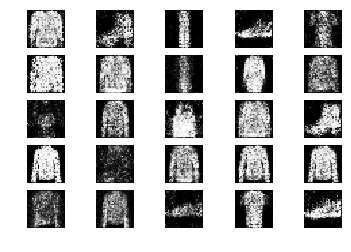

2601 [D loss: 0.677401, acc.: 51.56%] [G loss: 0.862071]
2602 [D loss: 0.622655, acc.: 65.62%] [G loss: 0.899569]
2603 [D loss: 0.624850, acc.: 65.62%] [G loss: 1.016612]
2604 [D loss: 0.697664, acc.: 53.12%] [G loss: 0.977366]
2605 [D loss: 0.684764, acc.: 53.12%] [G loss: 0.990053]
2606 [D loss: 0.618034, acc.: 60.94%] [G loss: 0.977831]
2607 [D loss: 0.654523, acc.: 62.50%] [G loss: 0.964539]
2608 [D loss: 0.739252, acc.: 46.88%] [G loss: 0.955249]
2609 [D loss: 0.655522, acc.: 57.81%] [G loss: 0.894461]
2610 [D loss: 0.642842, acc.: 64.06%] [G loss: 1.047914]
2611 [D loss: 0.770947, acc.: 45.31%] [G loss: 0.929143]
2612 [D loss: 0.680420, acc.: 62.50%] [G loss: 0.975543]
2613 [D loss: 0.676507, acc.: 59.38%] [G loss: 1.000525]
2614 [D loss: 0.650235, acc.: 60.94%] [G loss: 0.942180]
2615 [D loss: 0.590800, acc.: 76.56%] [G loss: 0.958907]
2616 [D loss: 0.596716, acc.: 71.88%] [G loss: 1.140432]
2617 [D loss: 0.657374, acc.: 56.25%] [G loss: 0.872856]
2618 [D loss: 0.591552, acc.: 7

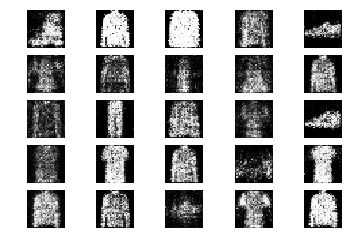

2651 [D loss: 0.643870, acc.: 62.50%] [G loss: 1.035657]
2652 [D loss: 0.586383, acc.: 71.88%] [G loss: 0.986353]
2653 [D loss: 0.655522, acc.: 57.81%] [G loss: 0.954962]
2654 [D loss: 0.604487, acc.: 73.44%] [G loss: 0.964434]
2655 [D loss: 0.646333, acc.: 67.19%] [G loss: 0.957213]
2656 [D loss: 0.608007, acc.: 70.31%] [G loss: 1.067069]
2657 [D loss: 0.672750, acc.: 57.81%] [G loss: 0.924155]
2658 [D loss: 0.582856, acc.: 70.31%] [G loss: 0.933245]
2659 [D loss: 0.580205, acc.: 70.31%] [G loss: 0.954830]
2660 [D loss: 0.639134, acc.: 70.31%] [G loss: 1.019979]
2661 [D loss: 0.634653, acc.: 67.19%] [G loss: 0.928508]
2662 [D loss: 0.676595, acc.: 56.25%] [G loss: 0.863780]
2663 [D loss: 0.627167, acc.: 60.94%] [G loss: 0.846772]
2664 [D loss: 0.714100, acc.: 50.00%] [G loss: 0.978420]
2665 [D loss: 0.577377, acc.: 67.19%] [G loss: 0.828435]
2666 [D loss: 0.618892, acc.: 68.75%] [G loss: 0.965132]
2667 [D loss: 0.556847, acc.: 75.00%] [G loss: 0.966110]
2668 [D loss: 0.606916, acc.: 6

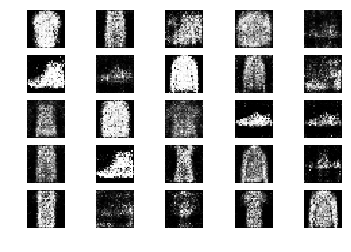

2701 [D loss: 0.625370, acc.: 60.94%] [G loss: 1.030592]
2702 [D loss: 0.681928, acc.: 56.25%] [G loss: 0.929988]
2703 [D loss: 0.618591, acc.: 70.31%] [G loss: 0.921682]
2704 [D loss: 0.634200, acc.: 62.50%] [G loss: 0.930782]
2705 [D loss: 0.579507, acc.: 71.88%] [G loss: 0.947444]
2706 [D loss: 0.619964, acc.: 70.31%] [G loss: 0.952116]
2707 [D loss: 0.663703, acc.: 59.38%] [G loss: 0.972492]
2708 [D loss: 0.593928, acc.: 70.31%] [G loss: 0.978521]
2709 [D loss: 0.639416, acc.: 60.94%] [G loss: 0.979253]
2710 [D loss: 0.625362, acc.: 71.88%] [G loss: 0.988450]
2711 [D loss: 0.569735, acc.: 65.62%] [G loss: 0.909221]
2712 [D loss: 0.622307, acc.: 67.19%] [G loss: 1.011512]
2713 [D loss: 0.540657, acc.: 71.88%] [G loss: 1.041714]
2714 [D loss: 0.639184, acc.: 62.50%] [G loss: 0.965806]
2715 [D loss: 0.613786, acc.: 62.50%] [G loss: 1.079233]
2716 [D loss: 0.604482, acc.: 67.19%] [G loss: 1.000103]
2717 [D loss: 0.670993, acc.: 56.25%] [G loss: 1.011555]
2718 [D loss: 0.579013, acc.: 7

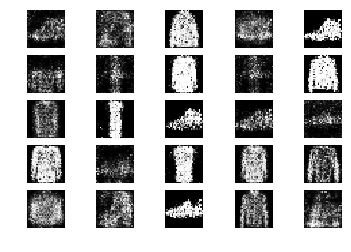

2751 [D loss: 0.617655, acc.: 64.06%] [G loss: 1.005479]
2752 [D loss: 0.647817, acc.: 54.69%] [G loss: 0.995548]
2753 [D loss: 0.649648, acc.: 59.38%] [G loss: 0.899613]
2754 [D loss: 0.659306, acc.: 67.19%] [G loss: 0.952249]
2755 [D loss: 0.616563, acc.: 65.62%] [G loss: 0.900939]
2756 [D loss: 0.708362, acc.: 60.94%] [G loss: 0.928984]
2757 [D loss: 0.562695, acc.: 73.44%] [G loss: 0.937214]
2758 [D loss: 0.584136, acc.: 73.44%] [G loss: 0.934136]
2759 [D loss: 0.602588, acc.: 68.75%] [G loss: 0.992857]
2760 [D loss: 0.643196, acc.: 70.31%] [G loss: 0.935256]
2761 [D loss: 0.564421, acc.: 68.75%] [G loss: 0.904026]
2762 [D loss: 0.622731, acc.: 67.19%] [G loss: 1.040058]
2763 [D loss: 0.595950, acc.: 70.31%] [G loss: 0.967046]
2764 [D loss: 0.578462, acc.: 70.31%] [G loss: 1.006324]
2765 [D loss: 0.620277, acc.: 70.31%] [G loss: 0.953386]
2766 [D loss: 0.623902, acc.: 65.62%] [G loss: 0.917118]
2767 [D loss: 0.595315, acc.: 70.31%] [G loss: 0.959665]
2768 [D loss: 0.653263, acc.: 6

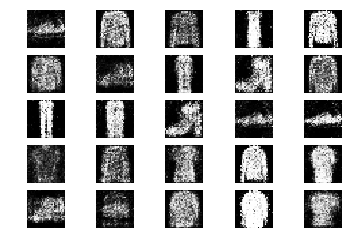

2801 [D loss: 0.629825, acc.: 67.19%] [G loss: 0.988691]
2802 [D loss: 0.680612, acc.: 57.81%] [G loss: 1.011546]
2803 [D loss: 0.625312, acc.: 64.06%] [G loss: 1.013825]
2804 [D loss: 0.698156, acc.: 57.81%] [G loss: 0.915564]
2805 [D loss: 0.657943, acc.: 60.94%] [G loss: 0.955951]
2806 [D loss: 0.653374, acc.: 53.12%] [G loss: 1.022260]
2807 [D loss: 0.608675, acc.: 68.75%] [G loss: 0.888555]
2808 [D loss: 0.660671, acc.: 60.94%] [G loss: 0.860147]
2809 [D loss: 0.594987, acc.: 67.19%] [G loss: 0.931719]
2810 [D loss: 0.614062, acc.: 67.19%] [G loss: 0.953239]
2811 [D loss: 0.591640, acc.: 68.75%] [G loss: 0.991354]
2812 [D loss: 0.656241, acc.: 59.38%] [G loss: 1.019500]
2813 [D loss: 0.601162, acc.: 73.44%] [G loss: 1.068206]
2814 [D loss: 0.662038, acc.: 53.12%] [G loss: 0.952411]
2815 [D loss: 0.673072, acc.: 64.06%] [G loss: 0.974977]
2816 [D loss: 0.615279, acc.: 68.75%] [G loss: 1.012655]
2817 [D loss: 0.626670, acc.: 60.94%] [G loss: 0.899456]
2818 [D loss: 0.657295, acc.: 6

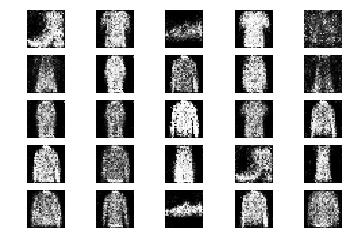

2851 [D loss: 0.574740, acc.: 71.88%] [G loss: 1.035354]
2852 [D loss: 0.630179, acc.: 65.62%] [G loss: 0.952458]
2853 [D loss: 0.677586, acc.: 65.62%] [G loss: 0.884850]
2854 [D loss: 0.629247, acc.: 67.19%] [G loss: 1.051774]
2855 [D loss: 0.633085, acc.: 60.94%] [G loss: 1.032489]
2856 [D loss: 0.646327, acc.: 70.31%] [G loss: 1.077358]
2857 [D loss: 0.659194, acc.: 51.56%] [G loss: 0.951536]
2858 [D loss: 0.672942, acc.: 56.25%] [G loss: 0.998160]
2859 [D loss: 0.622827, acc.: 68.75%] [G loss: 1.039797]
2860 [D loss: 0.597205, acc.: 64.06%] [G loss: 0.965913]
2861 [D loss: 0.596835, acc.: 75.00%] [G loss: 0.990462]
2862 [D loss: 0.659863, acc.: 59.38%] [G loss: 0.976152]
2863 [D loss: 0.688721, acc.: 60.94%] [G loss: 0.980181]
2864 [D loss: 0.684072, acc.: 51.56%] [G loss: 0.909892]
2865 [D loss: 0.703456, acc.: 60.94%] [G loss: 1.018737]
2866 [D loss: 0.678046, acc.: 62.50%] [G loss: 0.932802]
2867 [D loss: 0.628126, acc.: 56.25%] [G loss: 0.887749]
2868 [D loss: 0.605125, acc.: 6

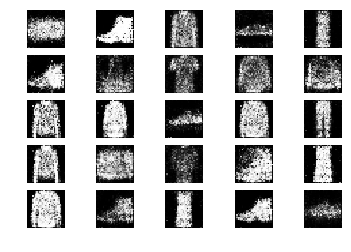

2901 [D loss: 0.645664, acc.: 60.94%] [G loss: 0.946129]
2902 [D loss: 0.695320, acc.: 54.69%] [G loss: 0.986651]
2903 [D loss: 0.654011, acc.: 56.25%] [G loss: 0.953994]
2904 [D loss: 0.703258, acc.: 54.69%] [G loss: 0.911751]
2905 [D loss: 0.684908, acc.: 57.81%] [G loss: 1.021154]
2906 [D loss: 0.621942, acc.: 70.31%] [G loss: 0.890526]
2907 [D loss: 0.659863, acc.: 65.62%] [G loss: 0.835114]
2908 [D loss: 0.648000, acc.: 59.38%] [G loss: 0.928265]
2909 [D loss: 0.726756, acc.: 51.56%] [G loss: 0.867810]
2910 [D loss: 0.652371, acc.: 57.81%] [G loss: 0.921933]
2911 [D loss: 0.623715, acc.: 60.94%] [G loss: 0.987019]
2912 [D loss: 0.692599, acc.: 56.25%] [G loss: 0.889118]
2913 [D loss: 0.656855, acc.: 59.38%] [G loss: 0.937007]
2914 [D loss: 0.645061, acc.: 60.94%] [G loss: 0.897879]
2915 [D loss: 0.659732, acc.: 57.81%] [G loss: 0.903224]
2916 [D loss: 0.616660, acc.: 65.62%] [G loss: 0.985742]
2917 [D loss: 0.682107, acc.: 53.12%] [G loss: 0.995179]
2918 [D loss: 0.672817, acc.: 6

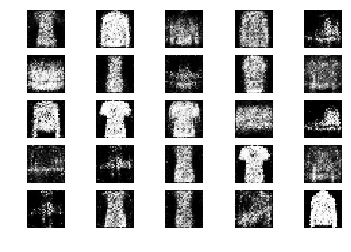

2951 [D loss: 0.610720, acc.: 62.50%] [G loss: 0.953493]
2952 [D loss: 0.630997, acc.: 57.81%] [G loss: 1.008687]
2953 [D loss: 0.670826, acc.: 57.81%] [G loss: 0.974546]
2954 [D loss: 0.629976, acc.: 67.19%] [G loss: 1.005837]
2955 [D loss: 0.666065, acc.: 62.50%] [G loss: 0.959168]
2956 [D loss: 0.616086, acc.: 62.50%] [G loss: 0.895515]
2957 [D loss: 0.650520, acc.: 60.94%] [G loss: 0.886145]
2958 [D loss: 0.606836, acc.: 67.19%] [G loss: 0.853215]
2959 [D loss: 0.655864, acc.: 64.06%] [G loss: 0.901522]
2960 [D loss: 0.636942, acc.: 62.50%] [G loss: 0.860378]
2961 [D loss: 0.598220, acc.: 65.62%] [G loss: 0.901949]
2962 [D loss: 0.667170, acc.: 59.38%] [G loss: 1.031838]
2963 [D loss: 0.695627, acc.: 53.12%] [G loss: 0.897404]
2964 [D loss: 0.585118, acc.: 65.62%] [G loss: 0.905610]
2965 [D loss: 0.695827, acc.: 48.44%] [G loss: 0.962813]
2966 [D loss: 0.673749, acc.: 53.12%] [G loss: 0.935719]
2967 [D loss: 0.642932, acc.: 62.50%] [G loss: 0.936309]
2968 [D loss: 0.594147, acc.: 7

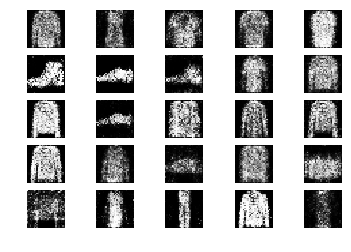

3001 [D loss: 0.649923, acc.: 56.25%] [G loss: 0.965666]
3002 [D loss: 0.565812, acc.: 75.00%] [G loss: 0.901103]
3003 [D loss: 0.660864, acc.: 64.06%] [G loss: 0.903000]
3004 [D loss: 0.584835, acc.: 73.44%] [G loss: 0.998133]
3005 [D loss: 0.694955, acc.: 53.12%] [G loss: 0.908828]
3006 [D loss: 0.631181, acc.: 64.06%] [G loss: 0.895315]
3007 [D loss: 0.576654, acc.: 73.44%] [G loss: 0.846218]
3008 [D loss: 0.613378, acc.: 62.50%] [G loss: 1.079374]
3009 [D loss: 0.630440, acc.: 68.75%] [G loss: 0.891140]
3010 [D loss: 0.632572, acc.: 62.50%] [G loss: 0.911547]
3011 [D loss: 0.692816, acc.: 59.38%] [G loss: 0.950613]
3012 [D loss: 0.689248, acc.: 56.25%] [G loss: 0.931580]
3013 [D loss: 0.613399, acc.: 67.19%] [G loss: 1.027555]
3014 [D loss: 0.653319, acc.: 60.94%] [G loss: 0.964738]
3015 [D loss: 0.601799, acc.: 67.19%] [G loss: 0.947406]
3016 [D loss: 0.705091, acc.: 57.81%] [G loss: 1.016772]
3017 [D loss: 0.684389, acc.: 53.12%] [G loss: 0.893883]
3018 [D loss: 0.606940, acc.: 6

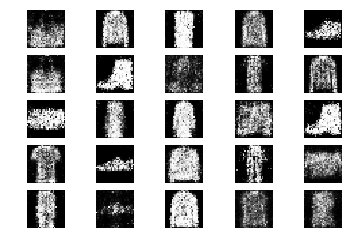

3051 [D loss: 0.623613, acc.: 65.62%] [G loss: 0.849305]
3052 [D loss: 0.636850, acc.: 65.62%] [G loss: 0.967321]
3053 [D loss: 0.661326, acc.: 62.50%] [G loss: 0.970359]
3054 [D loss: 0.578550, acc.: 78.12%] [G loss: 0.938342]
3055 [D loss: 0.608971, acc.: 68.75%] [G loss: 0.956609]
3056 [D loss: 0.582596, acc.: 68.75%] [G loss: 0.972177]
3057 [D loss: 0.595875, acc.: 70.31%] [G loss: 1.049852]
3058 [D loss: 0.674761, acc.: 62.50%] [G loss: 0.975475]
3059 [D loss: 0.633576, acc.: 65.62%] [G loss: 1.027618]
3060 [D loss: 0.692901, acc.: 59.38%] [G loss: 0.911548]
3061 [D loss: 0.648221, acc.: 62.50%] [G loss: 0.996884]
3062 [D loss: 0.680859, acc.: 54.69%] [G loss: 0.849120]
3063 [D loss: 0.606483, acc.: 70.31%] [G loss: 0.976199]
3064 [D loss: 0.686065, acc.: 57.81%] [G loss: 0.912569]
3065 [D loss: 0.590025, acc.: 71.88%] [G loss: 0.874565]
3066 [D loss: 0.633091, acc.: 67.19%] [G loss: 0.983687]
3067 [D loss: 0.745323, acc.: 42.19%] [G loss: 0.969205]
3068 [D loss: 0.603815, acc.: 6

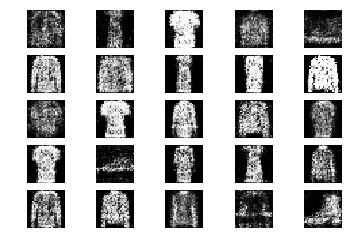

3101 [D loss: 0.713834, acc.: 56.25%] [G loss: 1.010140]
3102 [D loss: 0.724737, acc.: 56.25%] [G loss: 0.993036]
3103 [D loss: 0.646673, acc.: 56.25%] [G loss: 0.934887]
3104 [D loss: 0.614476, acc.: 67.19%] [G loss: 0.841233]
3105 [D loss: 0.608662, acc.: 64.06%] [G loss: 0.915893]
3106 [D loss: 0.668756, acc.: 54.69%] [G loss: 0.923365]
3107 [D loss: 0.682693, acc.: 65.62%] [G loss: 1.053495]
3108 [D loss: 0.660341, acc.: 60.94%] [G loss: 0.998218]
3109 [D loss: 0.595123, acc.: 76.56%] [G loss: 0.935175]
3110 [D loss: 0.640895, acc.: 57.81%] [G loss: 0.952332]
3111 [D loss: 0.607029, acc.: 64.06%] [G loss: 0.934319]
3112 [D loss: 0.619412, acc.: 67.19%] [G loss: 0.958780]
3113 [D loss: 0.651690, acc.: 59.38%] [G loss: 0.933839]
3114 [D loss: 0.634621, acc.: 67.19%] [G loss: 0.965240]
3115 [D loss: 0.584897, acc.: 73.44%] [G loss: 0.921356]
3116 [D loss: 0.556312, acc.: 75.00%] [G loss: 0.956460]
3117 [D loss: 0.714825, acc.: 57.81%] [G loss: 0.939845]
3118 [D loss: 0.646216, acc.: 6

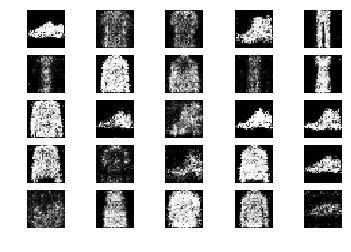

3151 [D loss: 0.621670, acc.: 65.62%] [G loss: 0.990920]
3152 [D loss: 0.702785, acc.: 53.12%] [G loss: 0.981714]
3153 [D loss: 0.690616, acc.: 60.94%] [G loss: 0.998591]
3154 [D loss: 0.700873, acc.: 59.38%] [G loss: 0.976831]
3155 [D loss: 0.647594, acc.: 60.94%] [G loss: 0.965170]
3156 [D loss: 0.590847, acc.: 70.31%] [G loss: 0.842045]
3157 [D loss: 0.598388, acc.: 70.31%] [G loss: 0.990701]
3158 [D loss: 0.620885, acc.: 53.12%] [G loss: 0.986118]
3159 [D loss: 0.687764, acc.: 54.69%] [G loss: 0.833444]
3160 [D loss: 0.646628, acc.: 62.50%] [G loss: 0.837718]
3161 [D loss: 0.658293, acc.: 59.38%] [G loss: 0.941037]
3162 [D loss: 0.696032, acc.: 54.69%] [G loss: 1.037568]
3163 [D loss: 0.690508, acc.: 51.56%] [G loss: 0.957176]
3164 [D loss: 0.706876, acc.: 48.44%] [G loss: 0.896156]
3165 [D loss: 0.617448, acc.: 64.06%] [G loss: 0.901943]
3166 [D loss: 0.725707, acc.: 50.00%] [G loss: 0.949452]
3167 [D loss: 0.593207, acc.: 75.00%] [G loss: 0.972988]
3168 [D loss: 0.602495, acc.: 7

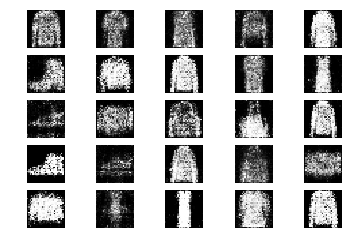

3201 [D loss: 0.616768, acc.: 65.62%] [G loss: 0.914754]
3202 [D loss: 0.620902, acc.: 64.06%] [G loss: 0.880693]
3203 [D loss: 0.657472, acc.: 62.50%] [G loss: 0.935212]
3204 [D loss: 0.581196, acc.: 67.19%] [G loss: 0.991937]
3205 [D loss: 0.614841, acc.: 67.19%] [G loss: 0.981791]
3206 [D loss: 0.635820, acc.: 57.81%] [G loss: 1.049705]
3207 [D loss: 0.644124, acc.: 64.06%] [G loss: 1.030585]
3208 [D loss: 0.638879, acc.: 59.38%] [G loss: 1.025604]
3209 [D loss: 0.711072, acc.: 53.12%] [G loss: 1.025705]
3210 [D loss: 0.626217, acc.: 59.38%] [G loss: 1.015528]
3211 [D loss: 0.629008, acc.: 62.50%] [G loss: 0.979399]
3212 [D loss: 0.705365, acc.: 60.94%] [G loss: 0.942853]
3213 [D loss: 0.628454, acc.: 60.94%] [G loss: 0.939888]
3214 [D loss: 0.649344, acc.: 57.81%] [G loss: 0.943496]
3215 [D loss: 0.662835, acc.: 59.38%] [G loss: 0.851278]
3216 [D loss: 0.598618, acc.: 71.88%] [G loss: 0.904301]
3217 [D loss: 0.585736, acc.: 70.31%] [G loss: 0.909551]
3218 [D loss: 0.683833, acc.: 5

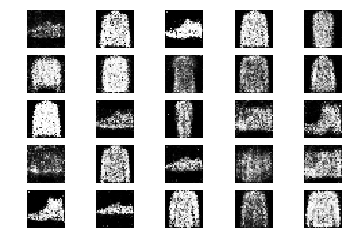

3251 [D loss: 0.600113, acc.: 65.62%] [G loss: 0.959721]
3252 [D loss: 0.630121, acc.: 62.50%] [G loss: 1.000774]
3253 [D loss: 0.589902, acc.: 68.75%] [G loss: 0.857058]
3254 [D loss: 0.609883, acc.: 60.94%] [G loss: 1.013519]
3255 [D loss: 0.656135, acc.: 59.38%] [G loss: 0.949860]
3256 [D loss: 0.569675, acc.: 70.31%] [G loss: 1.035296]
3257 [D loss: 0.588691, acc.: 73.44%] [G loss: 0.920692]
3258 [D loss: 0.591973, acc.: 73.44%] [G loss: 0.992855]
3259 [D loss: 0.733345, acc.: 54.69%] [G loss: 0.901131]
3260 [D loss: 0.611599, acc.: 71.88%] [G loss: 0.929811]
3261 [D loss: 0.630415, acc.: 67.19%] [G loss: 0.825736]
3262 [D loss: 0.653813, acc.: 64.06%] [G loss: 0.887573]
3263 [D loss: 0.657545, acc.: 60.94%] [G loss: 0.900161]
3264 [D loss: 0.677093, acc.: 57.81%] [G loss: 0.940252]
3265 [D loss: 0.561254, acc.: 76.56%] [G loss: 0.835955]
3266 [D loss: 0.622128, acc.: 65.62%] [G loss: 0.975916]
3267 [D loss: 0.657662, acc.: 64.06%] [G loss: 1.009626]
3268 [D loss: 0.623935, acc.: 6

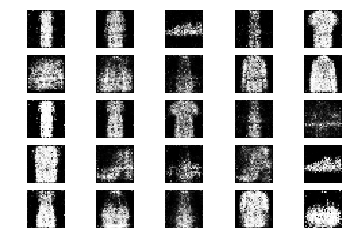

3301 [D loss: 0.684176, acc.: 53.12%] [G loss: 0.917408]
3302 [D loss: 0.598334, acc.: 64.06%] [G loss: 0.931525]
3303 [D loss: 0.628481, acc.: 65.62%] [G loss: 0.954971]
3304 [D loss: 0.725894, acc.: 50.00%] [G loss: 0.881957]
3305 [D loss: 0.618893, acc.: 71.88%] [G loss: 0.907162]
3306 [D loss: 0.724864, acc.: 53.12%] [G loss: 0.934789]
3307 [D loss: 0.685654, acc.: 57.81%] [G loss: 0.893346]
3308 [D loss: 0.621142, acc.: 65.62%] [G loss: 0.965344]
3309 [D loss: 0.642288, acc.: 59.38%] [G loss: 0.872414]
3310 [D loss: 0.689334, acc.: 59.38%] [G loss: 0.944091]
3311 [D loss: 0.655571, acc.: 64.06%] [G loss: 0.840618]
3312 [D loss: 0.610205, acc.: 64.06%] [G loss: 0.975758]
3313 [D loss: 0.641562, acc.: 64.06%] [G loss: 1.027557]
3314 [D loss: 0.602367, acc.: 70.31%] [G loss: 0.923382]
3315 [D loss: 0.641001, acc.: 64.06%] [G loss: 0.941123]
3316 [D loss: 0.694276, acc.: 60.94%] [G loss: 0.958069]
3317 [D loss: 0.619263, acc.: 64.06%] [G loss: 0.942373]
3318 [D loss: 0.651951, acc.: 6

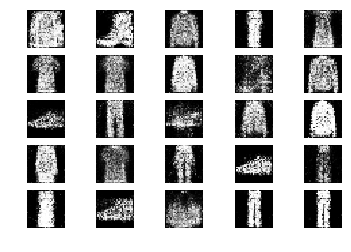

3351 [D loss: 0.693195, acc.: 57.81%] [G loss: 0.892742]
3352 [D loss: 0.624896, acc.: 62.50%] [G loss: 0.867023]
3353 [D loss: 0.662409, acc.: 60.94%] [G loss: 0.945202]
3354 [D loss: 0.735634, acc.: 45.31%] [G loss: 0.953127]
3355 [D loss: 0.540150, acc.: 84.38%] [G loss: 0.979903]
3356 [D loss: 0.692250, acc.: 56.25%] [G loss: 1.058606]
3357 [D loss: 0.721880, acc.: 50.00%] [G loss: 0.871455]
3358 [D loss: 0.617379, acc.: 62.50%] [G loss: 0.866439]
3359 [D loss: 0.636322, acc.: 59.38%] [G loss: 0.866250]
3360 [D loss: 0.698703, acc.: 56.25%] [G loss: 0.899462]
3361 [D loss: 0.544131, acc.: 76.56%] [G loss: 0.910223]
3362 [D loss: 0.615334, acc.: 67.19%] [G loss: 0.939432]
3363 [D loss: 0.565945, acc.: 73.44%] [G loss: 0.924507]
3364 [D loss: 0.687180, acc.: 56.25%] [G loss: 0.884081]
3365 [D loss: 0.604007, acc.: 68.75%] [G loss: 0.917454]
3366 [D loss: 0.649377, acc.: 65.62%] [G loss: 0.960665]
3367 [D loss: 0.639697, acc.: 65.62%] [G loss: 0.932991]
3368 [D loss: 0.641410, acc.: 6

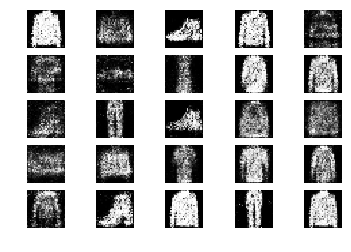

3401 [D loss: 0.606788, acc.: 73.44%] [G loss: 0.906904]
3402 [D loss: 0.593103, acc.: 76.56%] [G loss: 0.976917]
3403 [D loss: 0.643909, acc.: 54.69%] [G loss: 0.924710]
3404 [D loss: 0.584809, acc.: 76.56%] [G loss: 0.952780]
3405 [D loss: 0.534312, acc.: 76.56%] [G loss: 1.017421]
3406 [D loss: 0.605603, acc.: 62.50%] [G loss: 0.988665]
3407 [D loss: 0.642467, acc.: 65.62%] [G loss: 1.030700]
3408 [D loss: 0.657691, acc.: 53.12%] [G loss: 0.957080]
3409 [D loss: 0.664905, acc.: 59.38%] [G loss: 0.933469]
3410 [D loss: 0.687474, acc.: 53.12%] [G loss: 0.948913]
3411 [D loss: 0.595078, acc.: 64.06%] [G loss: 0.858408]
3412 [D loss: 0.652788, acc.: 57.81%] [G loss: 0.949538]
3413 [D loss: 0.582540, acc.: 71.88%] [G loss: 0.937498]
3414 [D loss: 0.611904, acc.: 64.06%] [G loss: 0.879910]
3415 [D loss: 0.651233, acc.: 54.69%] [G loss: 0.992176]
3416 [D loss: 0.710675, acc.: 54.69%] [G loss: 0.914002]
3417 [D loss: 0.689068, acc.: 56.25%] [G loss: 0.962415]
3418 [D loss: 0.646272, acc.: 6

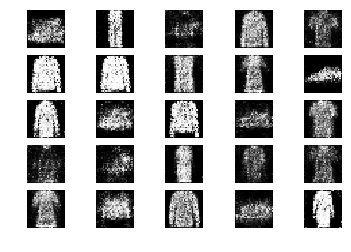

3451 [D loss: 0.668848, acc.: 57.81%] [G loss: 0.884914]
3452 [D loss: 0.584611, acc.: 65.62%] [G loss: 0.965391]
3453 [D loss: 0.725782, acc.: 48.44%] [G loss: 1.028694]
3454 [D loss: 0.712661, acc.: 50.00%] [G loss: 0.924580]
3455 [D loss: 0.693346, acc.: 54.69%] [G loss: 0.915445]
3456 [D loss: 0.612514, acc.: 64.06%] [G loss: 0.890190]
3457 [D loss: 0.574492, acc.: 70.31%] [G loss: 1.008345]
3458 [D loss: 0.572211, acc.: 65.62%] [G loss: 0.987929]
3459 [D loss: 0.636412, acc.: 54.69%] [G loss: 0.981937]
3460 [D loss: 0.620672, acc.: 57.81%] [G loss: 1.018026]
3461 [D loss: 0.623995, acc.: 68.75%] [G loss: 0.963025]
3462 [D loss: 0.689565, acc.: 54.69%] [G loss: 0.850581]
3463 [D loss: 0.628041, acc.: 70.31%] [G loss: 0.845148]
3464 [D loss: 0.713634, acc.: 50.00%] [G loss: 0.881213]
3465 [D loss: 0.591063, acc.: 73.44%] [G loss: 0.899445]
3466 [D loss: 0.618160, acc.: 64.06%] [G loss: 0.951082]
3467 [D loss: 0.616431, acc.: 65.62%] [G loss: 0.947694]
3468 [D loss: 0.644759, acc.: 6

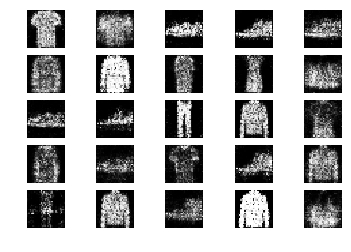

3501 [D loss: 0.639170, acc.: 70.31%] [G loss: 0.958949]
3502 [D loss: 0.662067, acc.: 60.94%] [G loss: 0.935281]
3503 [D loss: 0.646161, acc.: 60.94%] [G loss: 0.947566]
3504 [D loss: 0.677716, acc.: 53.12%] [G loss: 0.966085]
3505 [D loss: 0.659516, acc.: 50.00%] [G loss: 0.947381]
3506 [D loss: 0.665786, acc.: 57.81%] [G loss: 0.983033]
3507 [D loss: 0.614822, acc.: 76.56%] [G loss: 0.970946]
3508 [D loss: 0.663928, acc.: 56.25%] [G loss: 0.881926]
3509 [D loss: 0.723961, acc.: 50.00%] [G loss: 0.969725]
3510 [D loss: 0.715114, acc.: 42.19%] [G loss: 0.929062]
3511 [D loss: 0.560014, acc.: 84.38%] [G loss: 0.936520]
3512 [D loss: 0.615636, acc.: 68.75%] [G loss: 0.837606]
3513 [D loss: 0.653106, acc.: 62.50%] [G loss: 0.920255]
3514 [D loss: 0.541913, acc.: 78.12%] [G loss: 0.902279]
3515 [D loss: 0.608547, acc.: 67.19%] [G loss: 0.875819]
3516 [D loss: 0.645969, acc.: 57.81%] [G loss: 0.983752]
3517 [D loss: 0.630106, acc.: 65.62%] [G loss: 1.018011]
3518 [D loss: 0.644034, acc.: 6

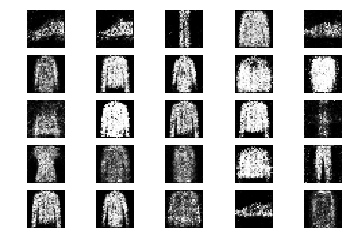

3551 [D loss: 0.630647, acc.: 59.38%] [G loss: 1.002870]
3552 [D loss: 0.577610, acc.: 79.69%] [G loss: 0.904488]
3553 [D loss: 0.644232, acc.: 57.81%] [G loss: 0.964959]
3554 [D loss: 0.725194, acc.: 56.25%] [G loss: 0.874506]
3555 [D loss: 0.648140, acc.: 57.81%] [G loss: 1.008064]
3556 [D loss: 0.677810, acc.: 60.94%] [G loss: 0.936082]
3557 [D loss: 0.622876, acc.: 64.06%] [G loss: 0.967185]
3558 [D loss: 0.683102, acc.: 60.94%] [G loss: 0.973455]
3559 [D loss: 0.651456, acc.: 62.50%] [G loss: 0.937191]
3560 [D loss: 0.614403, acc.: 68.75%] [G loss: 0.933577]
3561 [D loss: 0.611366, acc.: 73.44%] [G loss: 0.932685]
3562 [D loss: 0.655968, acc.: 64.06%] [G loss: 1.001254]
3563 [D loss: 0.698429, acc.: 48.44%] [G loss: 0.948707]
3564 [D loss: 0.624326, acc.: 62.50%] [G loss: 1.009725]
3565 [D loss: 0.612153, acc.: 64.06%] [G loss: 0.926650]
3566 [D loss: 0.656430, acc.: 62.50%] [G loss: 0.960716]
3567 [D loss: 0.597739, acc.: 65.62%] [G loss: 0.946268]
3568 [D loss: 0.628343, acc.: 6

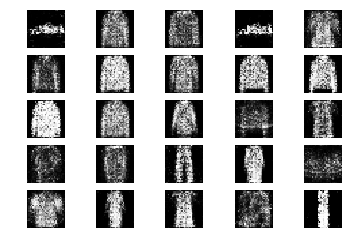

3601 [D loss: 0.614419, acc.: 67.19%] [G loss: 0.914654]
3602 [D loss: 0.616716, acc.: 56.25%] [G loss: 0.899329]
3603 [D loss: 0.650277, acc.: 59.38%] [G loss: 0.926051]
3604 [D loss: 0.627287, acc.: 67.19%] [G loss: 0.908297]
3605 [D loss: 0.671591, acc.: 57.81%] [G loss: 0.892118]
3606 [D loss: 0.705260, acc.: 50.00%] [G loss: 0.858758]
3607 [D loss: 0.613216, acc.: 60.94%] [G loss: 0.896345]
3608 [D loss: 0.599128, acc.: 71.88%] [G loss: 0.992876]
3609 [D loss: 0.625102, acc.: 64.06%] [G loss: 0.928627]
3610 [D loss: 0.624912, acc.: 62.50%] [G loss: 0.823254]
3611 [D loss: 0.649637, acc.: 62.50%] [G loss: 0.908224]
3612 [D loss: 0.659924, acc.: 53.12%] [G loss: 0.948809]
3613 [D loss: 0.634111, acc.: 70.31%] [G loss: 0.910900]
3614 [D loss: 0.686503, acc.: 65.62%] [G loss: 0.916683]
3615 [D loss: 0.693471, acc.: 54.69%] [G loss: 0.903291]
3616 [D loss: 0.625077, acc.: 68.75%] [G loss: 1.055061]
3617 [D loss: 0.613168, acc.: 65.62%] [G loss: 0.979281]
3618 [D loss: 0.681617, acc.: 5

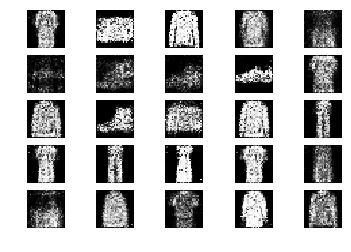

3651 [D loss: 0.688220, acc.: 56.25%] [G loss: 0.956165]
3652 [D loss: 0.631361, acc.: 67.19%] [G loss: 0.933484]
3653 [D loss: 0.619663, acc.: 70.31%] [G loss: 0.999138]
3654 [D loss: 0.655513, acc.: 59.38%] [G loss: 0.930847]
3655 [D loss: 0.656567, acc.: 54.69%] [G loss: 0.916231]
3656 [D loss: 0.660689, acc.: 57.81%] [G loss: 0.998255]
3657 [D loss: 0.627313, acc.: 67.19%] [G loss: 0.934928]
3658 [D loss: 0.660442, acc.: 65.62%] [G loss: 0.959845]
3659 [D loss: 0.596943, acc.: 65.62%] [G loss: 0.882311]
3660 [D loss: 0.644586, acc.: 64.06%] [G loss: 0.862857]
3661 [D loss: 0.641794, acc.: 65.62%] [G loss: 0.958999]
3662 [D loss: 0.728573, acc.: 56.25%] [G loss: 0.890580]
3663 [D loss: 0.706269, acc.: 54.69%] [G loss: 0.935583]
3664 [D loss: 0.717802, acc.: 45.31%] [G loss: 0.947965]
3665 [D loss: 0.664008, acc.: 56.25%] [G loss: 0.955494]
3666 [D loss: 0.601537, acc.: 71.88%] [G loss: 0.832922]
3667 [D loss: 0.626157, acc.: 67.19%] [G loss: 0.968440]
3668 [D loss: 0.603029, acc.: 6

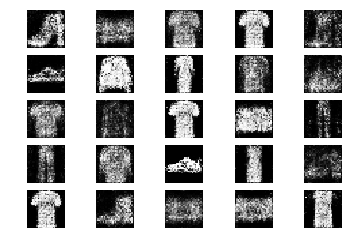

3701 [D loss: 0.589160, acc.: 70.31%] [G loss: 0.988545]
3702 [D loss: 0.678077, acc.: 53.12%] [G loss: 0.984434]
3703 [D loss: 0.659925, acc.: 51.56%] [G loss: 0.927772]
3704 [D loss: 0.659456, acc.: 64.06%] [G loss: 0.859269]
3705 [D loss: 0.645900, acc.: 51.56%] [G loss: 0.964511]
3706 [D loss: 0.677111, acc.: 54.69%] [G loss: 0.976172]
3707 [D loss: 0.716836, acc.: 60.94%] [G loss: 0.933742]
3708 [D loss: 0.683424, acc.: 54.69%] [G loss: 0.904053]
3709 [D loss: 0.624758, acc.: 67.19%] [G loss: 0.913505]
3710 [D loss: 0.734903, acc.: 62.50%] [G loss: 0.921727]
3711 [D loss: 0.646287, acc.: 64.06%] [G loss: 0.897687]
3712 [D loss: 0.670106, acc.: 60.94%] [G loss: 0.878587]
3713 [D loss: 0.656008, acc.: 56.25%] [G loss: 0.926543]
3714 [D loss: 0.632634, acc.: 54.69%] [G loss: 0.878253]
3715 [D loss: 0.692617, acc.: 56.25%] [G loss: 0.917563]
3716 [D loss: 0.624339, acc.: 65.62%] [G loss: 0.966803]
3717 [D loss: 0.673688, acc.: 60.94%] [G loss: 0.864649]
3718 [D loss: 0.694727, acc.: 5

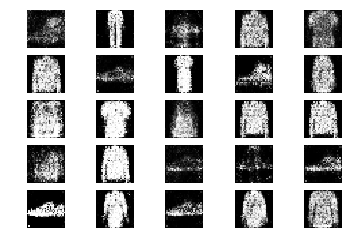

3751 [D loss: 0.613583, acc.: 65.62%] [G loss: 0.849624]
3752 [D loss: 0.690866, acc.: 62.50%] [G loss: 0.858254]
3753 [D loss: 0.620232, acc.: 67.19%] [G loss: 0.840328]
3754 [D loss: 0.662881, acc.: 59.38%] [G loss: 0.944270]
3755 [D loss: 0.641827, acc.: 68.75%] [G loss: 0.880000]
3756 [D loss: 0.742850, acc.: 51.56%] [G loss: 0.879349]
3757 [D loss: 0.644146, acc.: 62.50%] [G loss: 0.881468]
3758 [D loss: 0.634183, acc.: 59.38%] [G loss: 0.856838]
3759 [D loss: 0.716542, acc.: 48.44%] [G loss: 0.865924]
3760 [D loss: 0.623387, acc.: 65.62%] [G loss: 0.942467]
3761 [D loss: 0.600105, acc.: 67.19%] [G loss: 0.819583]
3762 [D loss: 0.636885, acc.: 62.50%] [G loss: 0.940693]
3763 [D loss: 0.694658, acc.: 48.44%] [G loss: 0.905114]
3764 [D loss: 0.665184, acc.: 57.81%] [G loss: 0.913095]
3765 [D loss: 0.614177, acc.: 71.88%] [G loss: 0.913624]
3766 [D loss: 0.578056, acc.: 71.88%] [G loss: 0.905797]
3767 [D loss: 0.663838, acc.: 64.06%] [G loss: 0.913703]
3768 [D loss: 0.608041, acc.: 6

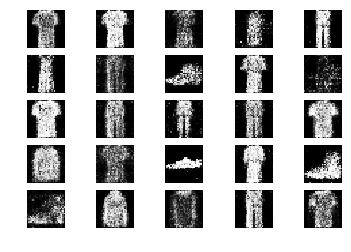

3801 [D loss: 0.733113, acc.: 56.25%] [G loss: 0.932655]
3802 [D loss: 0.616605, acc.: 59.38%] [G loss: 0.940772]
3803 [D loss: 0.600297, acc.: 64.06%] [G loss: 1.001691]
3804 [D loss: 0.732608, acc.: 51.56%] [G loss: 0.965939]
3805 [D loss: 0.644370, acc.: 62.50%] [G loss: 0.895012]
3806 [D loss: 0.701515, acc.: 53.12%] [G loss: 0.912692]
3807 [D loss: 0.637920, acc.: 64.06%] [G loss: 0.975950]
3808 [D loss: 0.649560, acc.: 65.62%] [G loss: 0.925567]
3809 [D loss: 0.591526, acc.: 76.56%] [G loss: 0.904035]
3810 [D loss: 0.666668, acc.: 53.12%] [G loss: 1.042874]
3811 [D loss: 0.645996, acc.: 68.75%] [G loss: 0.952974]
3812 [D loss: 0.675647, acc.: 67.19%] [G loss: 0.876317]
3813 [D loss: 0.649254, acc.: 60.94%] [G loss: 0.920227]
3814 [D loss: 0.608342, acc.: 70.31%] [G loss: 0.923359]
3815 [D loss: 0.606035, acc.: 68.75%] [G loss: 0.866863]
3816 [D loss: 0.571385, acc.: 75.00%] [G loss: 0.870836]
3817 [D loss: 0.674145, acc.: 59.38%] [G loss: 0.913523]
3818 [D loss: 0.637076, acc.: 6

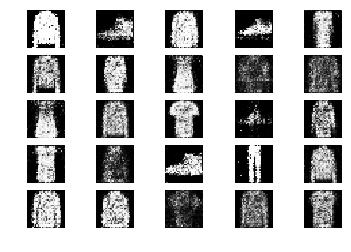

3851 [D loss: 0.565268, acc.: 73.44%] [G loss: 0.907484]
3852 [D loss: 0.719018, acc.: 59.38%] [G loss: 0.887810]
3853 [D loss: 0.661190, acc.: 59.38%] [G loss: 0.887874]
3854 [D loss: 0.687363, acc.: 67.19%] [G loss: 0.888313]
3855 [D loss: 0.645041, acc.: 57.81%] [G loss: 0.823699]
3856 [D loss: 0.622734, acc.: 65.62%] [G loss: 0.956514]
3857 [D loss: 0.668802, acc.: 57.81%] [G loss: 0.900014]
3858 [D loss: 0.625090, acc.: 59.38%] [G loss: 0.969388]
3859 [D loss: 0.599721, acc.: 65.62%] [G loss: 0.823838]
3860 [D loss: 0.585948, acc.: 71.88%] [G loss: 0.953113]
3861 [D loss: 0.690373, acc.: 57.81%] [G loss: 0.933373]
3862 [D loss: 0.627283, acc.: 59.38%] [G loss: 0.976333]
3863 [D loss: 0.614683, acc.: 65.62%] [G loss: 0.895104]
3864 [D loss: 0.623369, acc.: 65.62%] [G loss: 0.968357]
3865 [D loss: 0.677400, acc.: 59.38%] [G loss: 0.841571]
3866 [D loss: 0.720876, acc.: 57.81%] [G loss: 0.902698]
3867 [D loss: 0.626298, acc.: 65.62%] [G loss: 0.918152]
3868 [D loss: 0.638578, acc.: 6

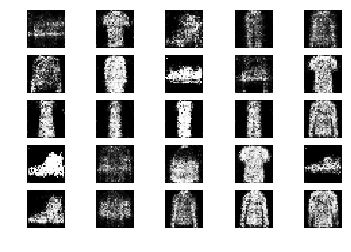

3901 [D loss: 0.677915, acc.: 51.56%] [G loss: 0.942331]
3902 [D loss: 0.620099, acc.: 56.25%] [G loss: 0.948047]
3903 [D loss: 0.651652, acc.: 68.75%] [G loss: 0.897853]
3904 [D loss: 0.635241, acc.: 68.75%] [G loss: 0.950696]
3905 [D loss: 0.591496, acc.: 65.62%] [G loss: 1.052392]
3906 [D loss: 0.705274, acc.: 50.00%] [G loss: 0.942640]
3907 [D loss: 0.665508, acc.: 59.38%] [G loss: 0.920906]
3908 [D loss: 0.664691, acc.: 59.38%] [G loss: 0.936790]
3909 [D loss: 0.619491, acc.: 64.06%] [G loss: 1.020322]
3910 [D loss: 0.652222, acc.: 60.94%] [G loss: 0.894423]
3911 [D loss: 0.656604, acc.: 56.25%] [G loss: 0.917319]
3912 [D loss: 0.688433, acc.: 53.12%] [G loss: 0.870669]
3913 [D loss: 0.617051, acc.: 62.50%] [G loss: 0.981532]
3914 [D loss: 0.680159, acc.: 57.81%] [G loss: 1.007738]
3915 [D loss: 0.633602, acc.: 68.75%] [G loss: 0.965914]
3916 [D loss: 0.611658, acc.: 68.75%] [G loss: 0.944342]
3917 [D loss: 0.679363, acc.: 53.12%] [G loss: 0.970413]
3918 [D loss: 0.689023, acc.: 5

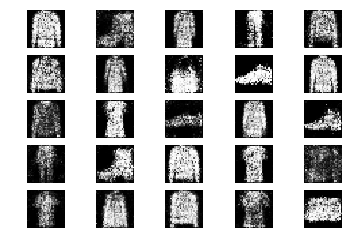

3951 [D loss: 0.612811, acc.: 71.88%] [G loss: 0.948844]
3952 [D loss: 0.631191, acc.: 68.75%] [G loss: 0.941984]
3953 [D loss: 0.624895, acc.: 65.62%] [G loss: 0.895365]
3954 [D loss: 0.616040, acc.: 67.19%] [G loss: 0.889013]
3955 [D loss: 0.681230, acc.: 56.25%] [G loss: 0.977917]
3956 [D loss: 0.677152, acc.: 50.00%] [G loss: 1.037827]
3957 [D loss: 0.676773, acc.: 54.69%] [G loss: 0.969102]
3958 [D loss: 0.675303, acc.: 54.69%] [G loss: 0.897447]
3959 [D loss: 0.698220, acc.: 51.56%] [G loss: 0.944793]
3960 [D loss: 0.660621, acc.: 56.25%] [G loss: 0.950218]
3961 [D loss: 0.650284, acc.: 60.94%] [G loss: 0.868753]
3962 [D loss: 0.641982, acc.: 65.62%] [G loss: 0.998127]
3963 [D loss: 0.665673, acc.: 60.94%] [G loss: 0.929021]
3964 [D loss: 0.705157, acc.: 67.19%] [G loss: 0.955950]
3965 [D loss: 0.602101, acc.: 67.19%] [G loss: 0.949557]
3966 [D loss: 0.564465, acc.: 71.88%] [G loss: 0.931677]
3967 [D loss: 0.688503, acc.: 57.81%] [G loss: 0.938110]
3968 [D loss: 0.681762, acc.: 5

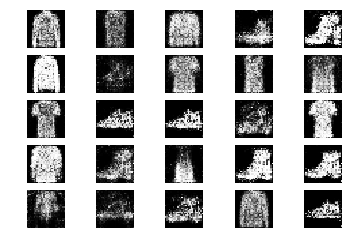

4001 [D loss: 0.674163, acc.: 62.50%] [G loss: 1.010286]
4002 [D loss: 0.642795, acc.: 65.62%] [G loss: 0.874270]
4003 [D loss: 0.680658, acc.: 56.25%] [G loss: 0.906176]
4004 [D loss: 0.633402, acc.: 62.50%] [G loss: 0.866634]
4005 [D loss: 0.636401, acc.: 64.06%] [G loss: 0.843027]
4006 [D loss: 0.636189, acc.: 59.38%] [G loss: 0.926654]
4007 [D loss: 0.700715, acc.: 53.12%] [G loss: 0.871531]
4008 [D loss: 0.669751, acc.: 51.56%] [G loss: 0.987105]
4009 [D loss: 0.612622, acc.: 65.62%] [G loss: 1.026240]
4010 [D loss: 0.651057, acc.: 59.38%] [G loss: 1.011080]
4011 [D loss: 0.729900, acc.: 54.69%] [G loss: 0.988800]
4012 [D loss: 0.611994, acc.: 64.06%] [G loss: 0.894452]
4013 [D loss: 0.608693, acc.: 65.62%] [G loss: 0.979619]
4014 [D loss: 0.687972, acc.: 56.25%] [G loss: 0.842745]
4015 [D loss: 0.749199, acc.: 51.56%] [G loss: 0.810230]
4016 [D loss: 0.583258, acc.: 71.88%] [G loss: 0.959272]
4017 [D loss: 0.670946, acc.: 59.38%] [G loss: 0.935981]
4018 [D loss: 0.600439, acc.: 7

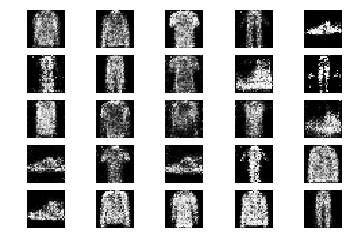

4051 [D loss: 0.701209, acc.: 53.12%] [G loss: 0.932526]
4052 [D loss: 0.642750, acc.: 60.94%] [G loss: 0.944721]
4053 [D loss: 0.618286, acc.: 64.06%] [G loss: 0.953640]
4054 [D loss: 0.749123, acc.: 45.31%] [G loss: 0.904205]
4055 [D loss: 0.691385, acc.: 62.50%] [G loss: 1.041182]
4056 [D loss: 0.702280, acc.: 51.56%] [G loss: 0.976555]
4057 [D loss: 0.688156, acc.: 60.94%] [G loss: 0.808804]
4058 [D loss: 0.630221, acc.: 56.25%] [G loss: 0.909536]
4059 [D loss: 0.646577, acc.: 59.38%] [G loss: 0.908291]
4060 [D loss: 0.614532, acc.: 68.75%] [G loss: 1.025701]
4061 [D loss: 0.704820, acc.: 53.12%] [G loss: 1.053552]
4062 [D loss: 0.698419, acc.: 53.12%] [G loss: 1.064777]
4063 [D loss: 0.692872, acc.: 62.50%] [G loss: 0.953684]
4064 [D loss: 0.713953, acc.: 54.69%] [G loss: 0.942086]
4065 [D loss: 0.686104, acc.: 67.19%] [G loss: 1.063860]
4066 [D loss: 0.668019, acc.: 56.25%] [G loss: 0.946481]
4067 [D loss: 0.649421, acc.: 65.62%] [G loss: 0.925028]
4068 [D loss: 0.667226, acc.: 6

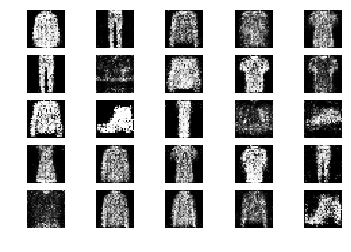

4101 [D loss: 0.553115, acc.: 75.00%] [G loss: 1.036581]
4102 [D loss: 0.624136, acc.: 59.38%] [G loss: 0.994949]
4103 [D loss: 0.671375, acc.: 53.12%] [G loss: 1.088979]
4104 [D loss: 0.673714, acc.: 59.38%] [G loss: 1.069129]
4105 [D loss: 0.643623, acc.: 71.88%] [G loss: 0.949887]
4106 [D loss: 0.652361, acc.: 65.62%] [G loss: 1.052393]
4107 [D loss: 0.651560, acc.: 65.62%] [G loss: 0.984714]
4108 [D loss: 0.663623, acc.: 62.50%] [G loss: 1.003003]
4109 [D loss: 0.555816, acc.: 70.31%] [G loss: 0.935535]
4110 [D loss: 0.652908, acc.: 56.25%] [G loss: 0.994965]
4111 [D loss: 0.629740, acc.: 59.38%] [G loss: 1.019029]
4112 [D loss: 0.667749, acc.: 54.69%] [G loss: 0.926148]
4113 [D loss: 0.681465, acc.: 54.69%] [G loss: 0.946959]
4114 [D loss: 0.594809, acc.: 70.31%] [G loss: 1.010826]
4115 [D loss: 0.581882, acc.: 67.19%] [G loss: 0.989635]
4116 [D loss: 0.656109, acc.: 60.94%] [G loss: 0.962491]
4117 [D loss: 0.693188, acc.: 59.38%] [G loss: 0.930241]
4118 [D loss: 0.621270, acc.: 6

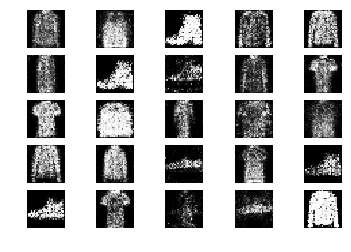

4151 [D loss: 0.689286, acc.: 43.75%] [G loss: 0.890157]
4152 [D loss: 0.668495, acc.: 59.38%] [G loss: 0.894839]
4153 [D loss: 0.675362, acc.: 53.12%] [G loss: 0.931332]
4154 [D loss: 0.656248, acc.: 56.25%] [G loss: 0.894016]
4155 [D loss: 0.684786, acc.: 57.81%] [G loss: 0.847711]
4156 [D loss: 0.635380, acc.: 62.50%] [G loss: 0.878488]
4157 [D loss: 0.658499, acc.: 60.94%] [G loss: 0.954721]
4158 [D loss: 0.675931, acc.: 59.38%] [G loss: 0.888541]
4159 [D loss: 0.636735, acc.: 67.19%] [G loss: 0.930089]
4160 [D loss: 0.645180, acc.: 70.31%] [G loss: 0.889225]
4161 [D loss: 0.755640, acc.: 56.25%] [G loss: 0.944985]
4162 [D loss: 0.654093, acc.: 64.06%] [G loss: 0.946010]
4163 [D loss: 0.634693, acc.: 60.94%] [G loss: 0.932820]
4164 [D loss: 0.658005, acc.: 62.50%] [G loss: 0.994047]
4165 [D loss: 0.645371, acc.: 59.38%] [G loss: 1.012189]
4166 [D loss: 0.627098, acc.: 64.06%] [G loss: 1.002319]
4167 [D loss: 0.658365, acc.: 54.69%] [G loss: 0.944683]
4168 [D loss: 0.558000, acc.: 7

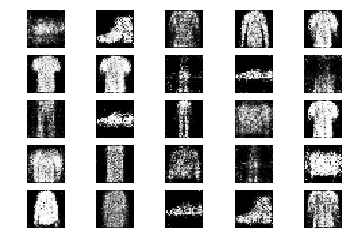

4201 [D loss: 0.645221, acc.: 64.06%] [G loss: 1.038775]
4202 [D loss: 0.661924, acc.: 60.94%] [G loss: 0.971149]
4203 [D loss: 0.661669, acc.: 57.81%] [G loss: 0.912608]
4204 [D loss: 0.642151, acc.: 62.50%] [G loss: 1.020634]
4205 [D loss: 0.640734, acc.: 59.38%] [G loss: 0.876955]
4206 [D loss: 0.617535, acc.: 68.75%] [G loss: 0.907701]
4207 [D loss: 0.627106, acc.: 64.06%] [G loss: 0.925635]
4208 [D loss: 0.645024, acc.: 60.94%] [G loss: 0.836075]
4209 [D loss: 0.609668, acc.: 68.75%] [G loss: 0.998957]
4210 [D loss: 0.628127, acc.: 59.38%] [G loss: 0.871838]
4211 [D loss: 0.675422, acc.: 60.94%] [G loss: 0.990222]
4212 [D loss: 0.601589, acc.: 68.75%] [G loss: 0.907956]
4213 [D loss: 0.584132, acc.: 67.19%] [G loss: 1.017911]
4214 [D loss: 0.729002, acc.: 48.44%] [G loss: 0.903234]
4215 [D loss: 0.640207, acc.: 64.06%] [G loss: 0.796528]
4216 [D loss: 0.619388, acc.: 65.62%] [G loss: 0.921879]
4217 [D loss: 0.735084, acc.: 45.31%] [G loss: 0.896328]
4218 [D loss: 0.590757, acc.: 7

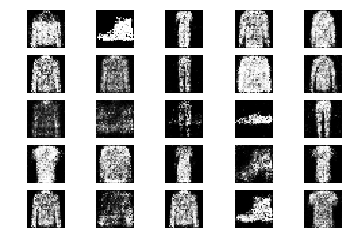

4251 [D loss: 0.720711, acc.: 46.88%] [G loss: 0.943740]
4252 [D loss: 0.620497, acc.: 67.19%] [G loss: 1.048621]
4253 [D loss: 0.689791, acc.: 59.38%] [G loss: 0.872586]
4254 [D loss: 0.686328, acc.: 54.69%] [G loss: 0.949955]
4255 [D loss: 0.573556, acc.: 75.00%] [G loss: 0.994008]
4256 [D loss: 0.631406, acc.: 67.19%] [G loss: 0.971715]
4257 [D loss: 0.647961, acc.: 65.62%] [G loss: 0.998551]
4258 [D loss: 0.671719, acc.: 54.69%] [G loss: 0.972998]
4259 [D loss: 0.696482, acc.: 57.81%] [G loss: 0.911583]
4260 [D loss: 0.632242, acc.: 67.19%] [G loss: 0.918984]
4261 [D loss: 0.634304, acc.: 57.81%] [G loss: 0.892718]
4262 [D loss: 0.730991, acc.: 54.69%] [G loss: 0.916188]
4263 [D loss: 0.643121, acc.: 62.50%] [G loss: 0.946153]
4264 [D loss: 0.574116, acc.: 71.88%] [G loss: 0.914400]
4265 [D loss: 0.675290, acc.: 60.94%] [G loss: 0.942818]
4266 [D loss: 0.619089, acc.: 64.06%] [G loss: 1.005722]
4267 [D loss: 0.635172, acc.: 56.25%] [G loss: 0.937948]
4268 [D loss: 0.632305, acc.: 6

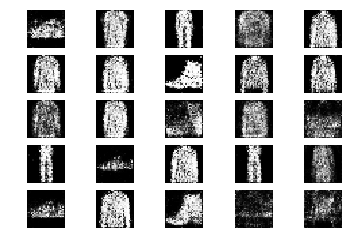

4301 [D loss: 0.676109, acc.: 50.00%] [G loss: 0.917529]
4302 [D loss: 0.607808, acc.: 67.19%] [G loss: 0.971163]
4303 [D loss: 0.602771, acc.: 67.19%] [G loss: 0.908564]
4304 [D loss: 0.628531, acc.: 65.62%] [G loss: 0.922453]
4305 [D loss: 0.669056, acc.: 57.81%] [G loss: 0.935199]
4306 [D loss: 0.627152, acc.: 65.62%] [G loss: 0.877918]
4307 [D loss: 0.742530, acc.: 50.00%] [G loss: 0.993089]
4308 [D loss: 0.658298, acc.: 54.69%] [G loss: 1.014496]
4309 [D loss: 0.667450, acc.: 57.81%] [G loss: 0.950952]
4310 [D loss: 0.630309, acc.: 70.31%] [G loss: 0.846368]
4311 [D loss: 0.647736, acc.: 62.50%] [G loss: 0.933022]
4312 [D loss: 0.653497, acc.: 67.19%] [G loss: 0.930915]
4313 [D loss: 0.658123, acc.: 60.94%] [G loss: 0.907726]
4314 [D loss: 0.631475, acc.: 65.62%] [G loss: 0.870066]
4315 [D loss: 0.649177, acc.: 60.94%] [G loss: 0.917631]
4316 [D loss: 0.530530, acc.: 82.81%] [G loss: 1.049753]
4317 [D loss: 0.637979, acc.: 54.69%] [G loss: 0.846466]
4318 [D loss: 0.761538, acc.: 4

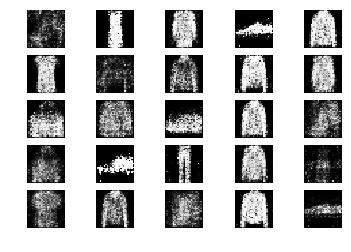

4351 [D loss: 0.640596, acc.: 60.94%] [G loss: 0.886562]
4352 [D loss: 0.618433, acc.: 68.75%] [G loss: 0.937424]
4353 [D loss: 0.677938, acc.: 54.69%] [G loss: 0.964075]
4354 [D loss: 0.575099, acc.: 70.31%] [G loss: 0.936139]
4355 [D loss: 0.647877, acc.: 59.38%] [G loss: 0.858053]
4356 [D loss: 0.664218, acc.: 60.94%] [G loss: 0.920510]
4357 [D loss: 0.647775, acc.: 59.38%] [G loss: 0.881168]
4358 [D loss: 0.739220, acc.: 48.44%] [G loss: 0.849683]
4359 [D loss: 0.601665, acc.: 62.50%] [G loss: 0.968193]
4360 [D loss: 0.600455, acc.: 73.44%] [G loss: 0.911086]
4361 [D loss: 0.653487, acc.: 62.50%] [G loss: 1.019620]
4362 [D loss: 0.678131, acc.: 64.06%] [G loss: 1.052819]
4363 [D loss: 0.686075, acc.: 62.50%] [G loss: 0.854276]
4364 [D loss: 0.641554, acc.: 62.50%] [G loss: 0.848394]
4365 [D loss: 0.638991, acc.: 59.38%] [G loss: 0.944703]
4366 [D loss: 0.664624, acc.: 54.69%] [G loss: 0.802886]
4367 [D loss: 0.677226, acc.: 53.12%] [G loss: 0.954237]
4368 [D loss: 0.628652, acc.: 6

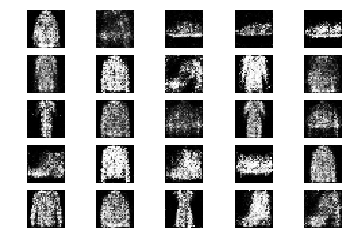

4401 [D loss: 0.647228, acc.: 65.62%] [G loss: 0.957515]
4402 [D loss: 0.674826, acc.: 62.50%] [G loss: 0.975328]
4403 [D loss: 0.619459, acc.: 65.62%] [G loss: 0.908295]
4404 [D loss: 0.667987, acc.: 57.81%] [G loss: 0.928534]
4405 [D loss: 0.653924, acc.: 75.00%] [G loss: 0.908978]
4406 [D loss: 0.581775, acc.: 70.31%] [G loss: 0.943053]
4407 [D loss: 0.698612, acc.: 51.56%] [G loss: 0.925289]
4408 [D loss: 0.673419, acc.: 64.06%] [G loss: 0.931012]
4409 [D loss: 0.692201, acc.: 54.69%] [G loss: 0.922712]
4410 [D loss: 0.645910, acc.: 64.06%] [G loss: 0.937749]
4411 [D loss: 0.547762, acc.: 75.00%] [G loss: 0.949523]
4412 [D loss: 0.618166, acc.: 65.62%] [G loss: 1.086241]
4413 [D loss: 0.615166, acc.: 64.06%] [G loss: 0.968194]
4414 [D loss: 0.605806, acc.: 65.62%] [G loss: 1.014969]
4415 [D loss: 0.635579, acc.: 65.62%] [G loss: 0.875841]
4416 [D loss: 0.618203, acc.: 67.19%] [G loss: 0.912303]
4417 [D loss: 0.698467, acc.: 51.56%] [G loss: 1.006467]
4418 [D loss: 0.715925, acc.: 5

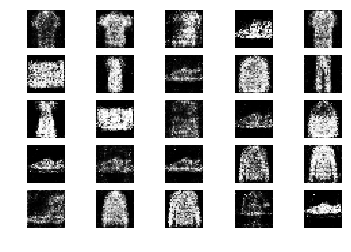

4451 [D loss: 0.706241, acc.: 57.81%] [G loss: 0.903000]
4452 [D loss: 0.662318, acc.: 56.25%] [G loss: 0.967913]
4453 [D loss: 0.657894, acc.: 59.38%] [G loss: 0.997997]
4454 [D loss: 0.593704, acc.: 62.50%] [G loss: 0.964568]
4455 [D loss: 0.609404, acc.: 67.19%] [G loss: 0.894269]
4456 [D loss: 0.668689, acc.: 60.94%] [G loss: 0.982509]
4457 [D loss: 0.687075, acc.: 56.25%] [G loss: 0.922664]
4458 [D loss: 0.705674, acc.: 54.69%] [G loss: 0.863690]
4459 [D loss: 0.671706, acc.: 59.38%] [G loss: 0.862589]
4460 [D loss: 0.636432, acc.: 59.38%] [G loss: 1.051213]
4461 [D loss: 0.747351, acc.: 48.44%] [G loss: 1.022566]
4462 [D loss: 0.667029, acc.: 56.25%] [G loss: 1.014015]
4463 [D loss: 0.632040, acc.: 64.06%] [G loss: 0.947209]
4464 [D loss: 0.582144, acc.: 68.75%] [G loss: 0.988494]
4465 [D loss: 0.615761, acc.: 67.19%] [G loss: 0.915708]
4466 [D loss: 0.631291, acc.: 67.19%] [G loss: 1.022773]
4467 [D loss: 0.589523, acc.: 68.75%] [G loss: 0.955582]
4468 [D loss: 0.600733, acc.: 6

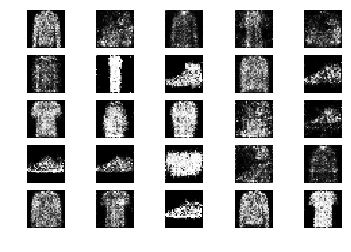

4501 [D loss: 0.680642, acc.: 60.94%] [G loss: 0.939242]
4502 [D loss: 0.700725, acc.: 53.12%] [G loss: 0.994126]
4503 [D loss: 0.679229, acc.: 64.06%] [G loss: 0.985535]
4504 [D loss: 0.579299, acc.: 70.31%] [G loss: 0.911416]
4505 [D loss: 0.651130, acc.: 57.81%] [G loss: 0.976168]
4506 [D loss: 0.623352, acc.: 64.06%] [G loss: 0.882449]
4507 [D loss: 0.624616, acc.: 60.94%] [G loss: 0.876582]
4508 [D loss: 0.722754, acc.: 56.25%] [G loss: 0.946184]
4509 [D loss: 0.701123, acc.: 57.81%] [G loss: 0.970491]
4510 [D loss: 0.647293, acc.: 57.81%] [G loss: 0.948708]
4511 [D loss: 0.674042, acc.: 57.81%] [G loss: 0.929849]
4512 [D loss: 0.652572, acc.: 68.75%] [G loss: 0.854900]
4513 [D loss: 0.626501, acc.: 62.50%] [G loss: 0.973103]
4514 [D loss: 0.651659, acc.: 59.38%] [G loss: 0.931958]
4515 [D loss: 0.643325, acc.: 60.94%] [G loss: 0.994432]
4516 [D loss: 0.616178, acc.: 65.62%] [G loss: 0.996780]
4517 [D loss: 0.691825, acc.: 60.94%] [G loss: 0.900711]
4518 [D loss: 0.599876, acc.: 7

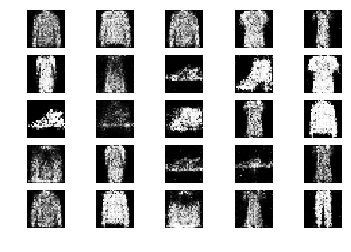

4551 [D loss: 0.607685, acc.: 65.62%] [G loss: 0.964060]
4552 [D loss: 0.623451, acc.: 65.62%] [G loss: 0.934214]
4553 [D loss: 0.666382, acc.: 60.94%] [G loss: 0.878131]
4554 [D loss: 0.655112, acc.: 64.06%] [G loss: 0.908386]
4555 [D loss: 0.563510, acc.: 76.56%] [G loss: 0.899638]
4556 [D loss: 0.636024, acc.: 70.31%] [G loss: 0.883595]
4557 [D loss: 0.618475, acc.: 62.50%] [G loss: 1.015066]
4558 [D loss: 0.657613, acc.: 59.38%] [G loss: 0.915232]
4559 [D loss: 0.707169, acc.: 57.81%] [G loss: 0.895201]
4560 [D loss: 0.668086, acc.: 59.38%] [G loss: 0.850131]
4561 [D loss: 0.629929, acc.: 67.19%] [G loss: 0.950063]
4562 [D loss: 0.695949, acc.: 42.19%] [G loss: 1.023068]
4563 [D loss: 0.614946, acc.: 68.75%] [G loss: 0.913862]
4564 [D loss: 0.632767, acc.: 57.81%] [G loss: 0.994667]
4565 [D loss: 0.689441, acc.: 51.56%] [G loss: 1.003912]
4566 [D loss: 0.562266, acc.: 73.44%] [G loss: 0.870544]
4567 [D loss: 0.634576, acc.: 59.38%] [G loss: 0.940266]
4568 [D loss: 0.673010, acc.: 5

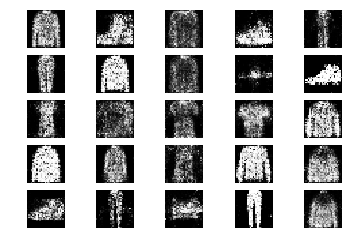

4601 [D loss: 0.659148, acc.: 57.81%] [G loss: 0.956499]
4602 [D loss: 0.665820, acc.: 56.25%] [G loss: 0.839776]
4603 [D loss: 0.675577, acc.: 53.12%] [G loss: 0.846798]
4604 [D loss: 0.603507, acc.: 71.88%] [G loss: 0.940569]
4605 [D loss: 0.642064, acc.: 57.81%] [G loss: 0.910090]
4606 [D loss: 0.608136, acc.: 60.94%] [G loss: 0.897471]
4607 [D loss: 0.630576, acc.: 67.19%] [G loss: 1.062806]
4608 [D loss: 0.713031, acc.: 57.81%] [G loss: 0.983416]
4609 [D loss: 0.656645, acc.: 59.38%] [G loss: 0.987837]
4610 [D loss: 0.620508, acc.: 73.44%] [G loss: 0.972699]
4611 [D loss: 0.688372, acc.: 54.69%] [G loss: 0.935830]
4612 [D loss: 0.662296, acc.: 64.06%] [G loss: 0.988323]
4613 [D loss: 0.653045, acc.: 56.25%] [G loss: 0.887830]
4614 [D loss: 0.654871, acc.: 54.69%] [G loss: 0.856602]
4615 [D loss: 0.630409, acc.: 64.06%] [G loss: 0.845262]
4616 [D loss: 0.686903, acc.: 53.12%] [G loss: 0.878596]
4617 [D loss: 0.641355, acc.: 65.62%] [G loss: 0.919058]
4618 [D loss: 0.636747, acc.: 6

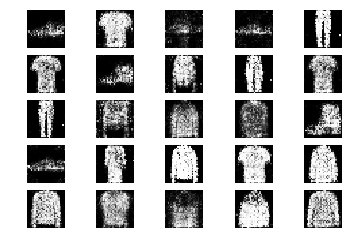

4651 [D loss: 0.682290, acc.: 51.56%] [G loss: 0.868898]
4652 [D loss: 0.678995, acc.: 54.69%] [G loss: 0.922821]
4653 [D loss: 0.620334, acc.: 64.06%] [G loss: 0.932915]
4654 [D loss: 0.611522, acc.: 68.75%] [G loss: 0.928695]
4655 [D loss: 0.669130, acc.: 54.69%] [G loss: 0.997008]
4656 [D loss: 0.640123, acc.: 59.38%] [G loss: 0.940366]
4657 [D loss: 0.639332, acc.: 57.81%] [G loss: 0.978096]
4658 [D loss: 0.634334, acc.: 71.88%] [G loss: 0.946327]
4659 [D loss: 0.700738, acc.: 53.12%] [G loss: 0.929214]
4660 [D loss: 0.618999, acc.: 64.06%] [G loss: 0.950341]
4661 [D loss: 0.708860, acc.: 54.69%] [G loss: 0.990678]
4662 [D loss: 0.658032, acc.: 68.75%] [G loss: 0.936222]
4663 [D loss: 0.603018, acc.: 62.50%] [G loss: 0.967962]
4664 [D loss: 0.690466, acc.: 54.69%] [G loss: 0.865463]
4665 [D loss: 0.681237, acc.: 56.25%] [G loss: 0.834585]
4666 [D loss: 0.659768, acc.: 50.00%] [G loss: 0.865747]
4667 [D loss: 0.620377, acc.: 64.06%] [G loss: 0.888021]
4668 [D loss: 0.647401, acc.: 5

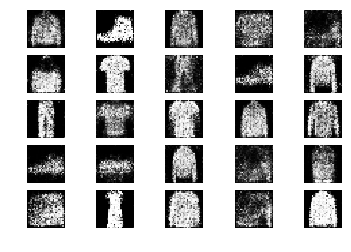

4701 [D loss: 0.608450, acc.: 73.44%] [G loss: 0.983300]
4702 [D loss: 0.681918, acc.: 57.81%] [G loss: 0.899045]
4703 [D loss: 0.653194, acc.: 62.50%] [G loss: 0.862813]
4704 [D loss: 0.600240, acc.: 67.19%] [G loss: 0.958253]
4705 [D loss: 0.571461, acc.: 71.88%] [G loss: 0.930838]
4706 [D loss: 0.683957, acc.: 57.81%] [G loss: 0.882807]
4707 [D loss: 0.558647, acc.: 79.69%] [G loss: 1.043720]
4708 [D loss: 0.685195, acc.: 56.25%] [G loss: 0.907774]
4709 [D loss: 0.623935, acc.: 64.06%] [G loss: 0.989730]
4710 [D loss: 0.712679, acc.: 48.44%] [G loss: 0.990043]
4711 [D loss: 0.580949, acc.: 70.31%] [G loss: 1.024287]
4712 [D loss: 0.645285, acc.: 60.94%] [G loss: 0.930110]
4713 [D loss: 0.610696, acc.: 68.75%] [G loss: 0.967590]
4714 [D loss: 0.652794, acc.: 59.38%] [G loss: 0.842040]
4715 [D loss: 0.691162, acc.: 48.44%] [G loss: 0.957482]
4716 [D loss: 0.701269, acc.: 59.38%] [G loss: 0.968549]
4717 [D loss: 0.669822, acc.: 64.06%] [G loss: 0.874444]
4718 [D loss: 0.694199, acc.: 5

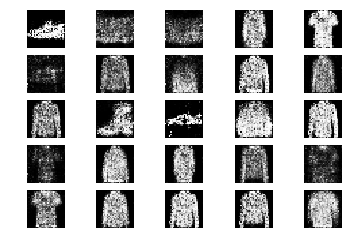

4751 [D loss: 0.624318, acc.: 73.44%] [G loss: 0.953166]
4752 [D loss: 0.617989, acc.: 67.19%] [G loss: 0.867559]
4753 [D loss: 0.626416, acc.: 64.06%] [G loss: 0.897819]
4754 [D loss: 0.628822, acc.: 60.94%] [G loss: 0.906595]
4755 [D loss: 0.624875, acc.: 71.88%] [G loss: 0.895877]
4756 [D loss: 0.698337, acc.: 59.38%] [G loss: 0.825885]
4757 [D loss: 0.676138, acc.: 50.00%] [G loss: 0.883589]
4758 [D loss: 0.584300, acc.: 70.31%] [G loss: 0.871635]
4759 [D loss: 0.602527, acc.: 64.06%] [G loss: 0.975926]
4760 [D loss: 0.660533, acc.: 54.69%] [G loss: 0.922848]
4761 [D loss: 0.621489, acc.: 68.75%] [G loss: 0.831896]
4762 [D loss: 0.653677, acc.: 56.25%] [G loss: 0.987575]
4763 [D loss: 0.640514, acc.: 64.06%] [G loss: 0.858481]
4764 [D loss: 0.683185, acc.: 53.12%] [G loss: 0.935767]
4765 [D loss: 0.598728, acc.: 67.19%] [G loss: 0.916147]
4766 [D loss: 0.678533, acc.: 50.00%] [G loss: 0.895352]
4767 [D loss: 0.699829, acc.: 51.56%] [G loss: 0.893305]
4768 [D loss: 0.639655, acc.: 6

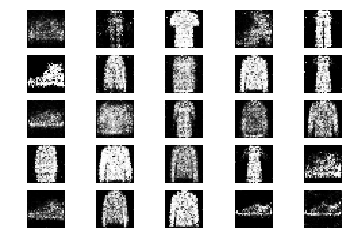

4801 [D loss: 0.731134, acc.: 56.25%] [G loss: 0.837156]
4802 [D loss: 0.725249, acc.: 45.31%] [G loss: 0.914041]
4803 [D loss: 0.635825, acc.: 62.50%] [G loss: 0.959275]
4804 [D loss: 0.627866, acc.: 68.75%] [G loss: 1.021198]
4805 [D loss: 0.645762, acc.: 53.12%] [G loss: 0.997131]
4806 [D loss: 0.590462, acc.: 73.44%] [G loss: 0.860425]
4807 [D loss: 0.662406, acc.: 50.00%] [G loss: 0.957320]
4808 [D loss: 0.663703, acc.: 54.69%] [G loss: 0.943412]
4809 [D loss: 0.665171, acc.: 56.25%] [G loss: 0.944853]
4810 [D loss: 0.648978, acc.: 56.25%] [G loss: 0.959570]
4811 [D loss: 0.621191, acc.: 67.19%] [G loss: 0.942289]
4812 [D loss: 0.634472, acc.: 59.38%] [G loss: 0.958877]
4813 [D loss: 0.693847, acc.: 57.81%] [G loss: 0.951930]
4814 [D loss: 0.611858, acc.: 64.06%] [G loss: 0.914144]
4815 [D loss: 0.587314, acc.: 71.88%] [G loss: 0.982656]
4816 [D loss: 0.704980, acc.: 46.88%] [G loss: 0.900862]
4817 [D loss: 0.618814, acc.: 67.19%] [G loss: 0.956597]
4818 [D loss: 0.622504, acc.: 6

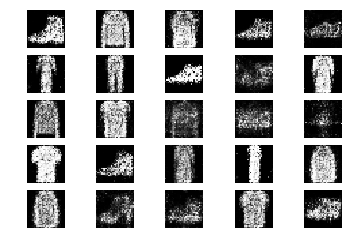

4851 [D loss: 0.704757, acc.: 56.25%] [G loss: 0.868218]
4852 [D loss: 0.637942, acc.: 73.44%] [G loss: 0.922304]
4853 [D loss: 0.720846, acc.: 48.44%] [G loss: 0.878750]
4854 [D loss: 0.595860, acc.: 73.44%] [G loss: 0.925395]
4855 [D loss: 0.624469, acc.: 68.75%] [G loss: 0.828490]
4856 [D loss: 0.694590, acc.: 60.94%] [G loss: 0.934436]
4857 [D loss: 0.675870, acc.: 54.69%] [G loss: 0.918040]
4858 [D loss: 0.753748, acc.: 39.06%] [G loss: 0.849071]
4859 [D loss: 0.603280, acc.: 67.19%] [G loss: 0.952825]
4860 [D loss: 0.628455, acc.: 62.50%] [G loss: 0.879937]
4861 [D loss: 0.699677, acc.: 56.25%] [G loss: 0.953404]
4862 [D loss: 0.628818, acc.: 65.62%] [G loss: 0.939770]
4863 [D loss: 0.617694, acc.: 67.19%] [G loss: 0.877391]
4864 [D loss: 0.673436, acc.: 51.56%] [G loss: 0.871668]
4865 [D loss: 0.644873, acc.: 56.25%] [G loss: 0.973246]
4866 [D loss: 0.660956, acc.: 59.38%] [G loss: 0.844833]
4867 [D loss: 0.611764, acc.: 64.06%] [G loss: 0.912325]
4868 [D loss: 0.694196, acc.: 5

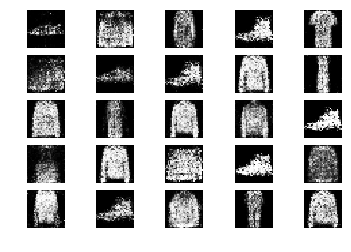

4901 [D loss: 0.665814, acc.: 64.06%] [G loss: 0.870553]
4902 [D loss: 0.667213, acc.: 62.50%] [G loss: 0.951727]
4903 [D loss: 0.606236, acc.: 71.88%] [G loss: 0.978571]
4904 [D loss: 0.662857, acc.: 60.94%] [G loss: 0.906475]
4905 [D loss: 0.642267, acc.: 59.38%] [G loss: 0.980841]
4906 [D loss: 0.712317, acc.: 54.69%] [G loss: 0.968838]
4907 [D loss: 0.631737, acc.: 57.81%] [G loss: 0.912936]
4908 [D loss: 0.675749, acc.: 60.94%] [G loss: 0.863912]
4909 [D loss: 0.663399, acc.: 62.50%] [G loss: 0.891927]
4910 [D loss: 0.599876, acc.: 68.75%] [G loss: 0.857905]
4911 [D loss: 0.678689, acc.: 56.25%] [G loss: 0.944498]
4912 [D loss: 0.611112, acc.: 65.62%] [G loss: 0.902875]
4913 [D loss: 0.682919, acc.: 57.81%] [G loss: 1.047385]
4914 [D loss: 0.667156, acc.: 59.38%] [G loss: 0.971869]
4915 [D loss: 0.619405, acc.: 57.81%] [G loss: 0.814801]
4916 [D loss: 0.579387, acc.: 75.00%] [G loss: 0.892029]
4917 [D loss: 0.620067, acc.: 70.31%] [G loss: 0.782516]
4918 [D loss: 0.681378, acc.: 5

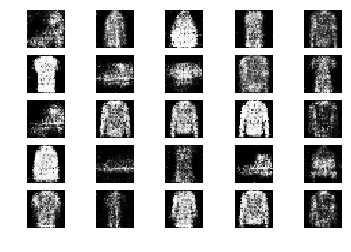

4951 [D loss: 0.647346, acc.: 67.19%] [G loss: 0.868695]
4952 [D loss: 0.685546, acc.: 62.50%] [G loss: 1.041817]
4953 [D loss: 0.690644, acc.: 54.69%] [G loss: 0.954676]
4954 [D loss: 0.637486, acc.: 65.62%] [G loss: 0.948296]
4955 [D loss: 0.666415, acc.: 54.69%] [G loss: 0.973034]
4956 [D loss: 0.618343, acc.: 68.75%] [G loss: 0.921899]
4957 [D loss: 0.682270, acc.: 59.38%] [G loss: 0.944105]
4958 [D loss: 0.663629, acc.: 54.69%] [G loss: 0.870877]
4959 [D loss: 0.666064, acc.: 57.81%] [G loss: 0.881682]
4960 [D loss: 0.611846, acc.: 71.88%] [G loss: 0.958723]
4961 [D loss: 0.697906, acc.: 54.69%] [G loss: 0.934073]
4962 [D loss: 0.651643, acc.: 62.50%] [G loss: 0.924504]
4963 [D loss: 0.603978, acc.: 65.62%] [G loss: 0.948270]
4964 [D loss: 0.641816, acc.: 67.19%] [G loss: 0.958310]
4965 [D loss: 0.586614, acc.: 71.88%] [G loss: 1.030813]
4966 [D loss: 0.667349, acc.: 65.62%] [G loss: 0.898826]
4967 [D loss: 0.624235, acc.: 60.94%] [G loss: 0.886425]
4968 [D loss: 0.660518, acc.: 6

In [26]:
epochs = 5000

batch_size = 32
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
  # Train discriminator
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]

  noise = np.random.normal(0, 1, (batch_size, 100))

  gen_imgs = generator.predict(noise)

  d_loss_real = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

  # Train generator
  noise = np.random.normal(0, 1, (batch_size, 100))

  g_loss = combined.train_on_batch(noise, valid)

  print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

  if epoch % 50 == 0:
    sample_images(epoch)

Return random integers from low (inclusive) to high (exclusive).

Return random integers from the “discrete uniform” distribution of the specified dtype in the “half-open” interval [low, high). If high is None (the default), then results are from [0, low).

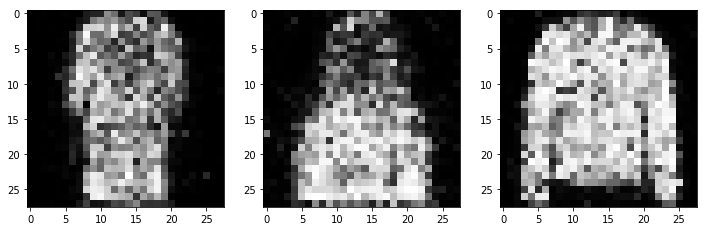

In [27]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r*c, 100))
gen_imgs = generator.predict(noise)

gen_imgs = 0.5*gen_imgs+0.5

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')
plt.subplot(132)
plt.imshow(gen_imgs[1, :, :, 0], cmap='gray')
plt.subplot(133)
plt.imshow(gen_imgs[2, :, :, 0], cmap='gray')
plt.show()
plt.close()